# Init

In [2]:
import numpy as np
import tensorflow as tf
import torch
import matplotlib.pyplot as plt
from numpy.polynomial import polynomial as P
from scipy.optimize import least_squares
from scipy.optimize import curve_fit
from scipy.stats import norm
import time
from IPython.display import display, clear_output
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn.functional as nF
import torch.optim as optim

In [ ]:
file_path = '/content/drive/MyDrive/magisterka/data_velopix/Module29_VP0-0_scan0_raw.csv'
velopix_data = np.loadtxt(fname=file_path, delimiter=",", skiprows=1)

# Imitating velo data operations

In [ ]:
reshaped_data = velopix_data.reshape(90, 256, 256)
transposed_data = reshaped_data.transpose(1, 2, 0)
np_data = transposed_data.reshape(65536, 90)
tensors_data = torch.Tensor(np_data)
tensors_data.shape

torch.Size([65536, 90])

In [ ]:
numpy_data = tensors_data.numpy()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def fit_line_two_points(x: np.ndarray, y: np.ndarray):
    """
    Fit a straight line through the two highest-index nonzero points of y(x).

    Parameters
    ----------
    x : 1D array of shape (N,)
        The threshold values (e.g. np.arange(1840, 1395, -5)).
    y : 1D array of shape (N,)
        The pixel noise counts at each threshold.

    Returns
    -------
    m : float
        Slope of the fitted line.
    b : float
        Intercept of the fitted line.
    i1, i2 : int, int
        The indices of the two nonzero points used for the fit.
    """
    # indices where y is nonzero
    nz = np.nonzero(y)[0]
    if nz.size < 2:
        raise ValueError("Need at least two non-zero points to fit a line.")

    # take the last two nonzero indices (rightmost)
    i1, i2 = nz[-1], nz[-2]
    x1, y1 = x[i1], y[i1]
    x2, y2 = x[i2], y[i2]

    # slope and intercept
    m = (y1 - y2) / (x1 - x2)
    b = y1 - m * x1
    return m, b, i1, i2

def plot_pixel_data_with_fit(y: np.ndarray,
                             x: np.ndarray = None,
                             x_start: int = 1840,
                             x_end:   int = 1395,
                             x_step:  int =  -5):
    """
    Scatter-plots a single pixel’s data and overlays the line fitted
    through the two rightmost nonzero points.

    Parameters
    ----------
    y : 1D array of length N
        Your pixel data (e.g. one row of tensors_data).
    x : 1D array of length N, optional
        The corresponding thresholds. If omitted, defaults to
        np.arange(x_start, x_end, x_step).
    x_start, x_end, x_step : ints
        Used only if x is None, to build the default threshold axis.
    """
    # build default x if needed
    if x is None:
        x = np.arange(x_start, x_end, x_step)
        if x.shape[0] != y.shape[0]:
            raise ValueError("Default axis length mismatch: "
                             f"{x.shape[0]} vs {y.shape[0]}")

    # fit line
    m, b, i1, i2 = fit_line_two_points(x, y)

    # plot
    plt.figure(figsize=(6,4))
    plt.scatter(x, y, marker='o', label='pixel data')
    # draw fit over full x-range
    x_line = np.array([x.min(), x.max()])
    y_line = m * x_line + b
    plt.plot(x_line, y_line,
             linestyle='--',
             label=f'fit from idx {i2}→{i1}\n$y$={m:.2f}$x$+{b:.2f}')
    plt.xlabel('DAC threshold')
    plt.ylabel('Noise counts')
    plt.title('Single-pixel noise vs. threshold')
    plt.legend()
    # if you want to show thresholds descending left→right:
    plt.gca().invert_xaxis()
    plt.tight_layout()
    plt.show()


In [ ]:
tensors_data[5]

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  3.,  3., 17., 63., 63.,
        63., 63., 63., 63., 63., 63., 63., 63., 63., 63., 63., 63., 63., 63.,
        63.,  3.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.])

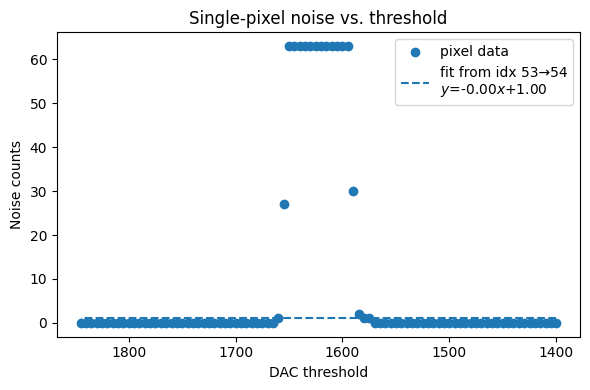

In [ ]:
thr = np.arange(1845, 1395, -5)
plot_pixel_data_with_fit(numpy_data[100], thr)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def fit_line_two_distinct_points(x, y):
    """
    Fit a line through the rightmost nonzero point and the nearest left
    point whose y-value differs from it.

    Parameters
    ----------
    x : array-like of shape (N,)
        Threshold axis.
    y : array-like of shape (N,)
        Pixel counts.

    Returns
    -------
    m, b : float
        Slope and intercept of the fitted line y = m x + b.
    i1, i2 : int
        Indices of the two points used.
    """
    # convert torch → numpy if needed
    if isinstance(y, torch.Tensor):
        y = y.detach().cpu().numpy()
    else:
        y = np.asarray(y)
    if isinstance(x, torch.Tensor):
        x = x.detach().cpu().numpy()
    else:
        x = np.asarray(x)

    if y.ndim != 1 or x.ndim != 1 or x.shape != y.shape:
        raise ValueError("x and y must be 1D and the same length")

    # find all nonzero indices
    nz = np.nonzero(y)[0]
    if nz.size < 2:
        raise ValueError("Need at least two non-zero points to fit a line.")

    # rightmost nonzero
    i1 = nz[-1]
    y1 = y[i1]

    # walk left until you find a different y-value
    for i2 in nz[:-1][::-1]:
        if y[i2] != y1:
            break
    else:
        raise ValueError("All nonzero points have the same value—cannot find a distinct second point.")

    x1, x2 = x[i1], x[i2]
    y2 = y[i2]

    m = (y1 - y2) / (x1 - x2)
    b = y1 - m * x1

    return m, b, i1, i2

def plot_pixel_with_distinct_fit(y, x=None,
                                 x_start=1845, x_end=1395, x_step=-5):
    """
    Scatter your pixel data and overlay the two-point fit, avoiding
    equal-value pairs.

    Parameters
    ----------
    y : array-like of shape (N,) or torch.Tensor
        Pixel counts.
    x : array-like of shape (N,) or torch.Tensor, optional
        Thresholds. If None, builds np.arange(x_start, x_end, x_step).
    """
    # build or convert x
    if x is None:
        x = np.arange(x_start, x_end, x_step)
    if isinstance(x, torch.Tensor):
        x = x.detach().cpu().numpy()
    else:
        x = np.asarray(x)

    # fit
    m, b, i1, i2 = fit_line_two_distinct_points(x, y)

    # convert y for plotting
    if isinstance(y, torch.Tensor):
        y = y.detach().cpu().numpy()
    else:
        y = np.asarray(y)

    # plot
    plt.figure(figsize=(6,4))
    plt.scatter(x, y, s=20, label='pixel data')
    # highlight the two fit points
    plt.scatter([x[i1], x[i2]], [y[i1], y[i2]],
                s=80, facecolors='none', edgecolors='r',
                label=f'fit points idx {i2}→{i1}')
    # draw fitted line
    x_line = np.array([x.min(), x.max()])
    y_line = m * x_line + b
    plt.plot(x_line, y_line, '--', label=f'y={m:.2f}x+{b:.2f}')
    plt.xlabel('DAC threshold')
    plt.ylabel('Noise counts')
    plt.title('Single-pixel noise vs. threshold')
    plt.legend()
    plt.gca().invert_xaxis()
    plt.tight_layout()
    plt.show()


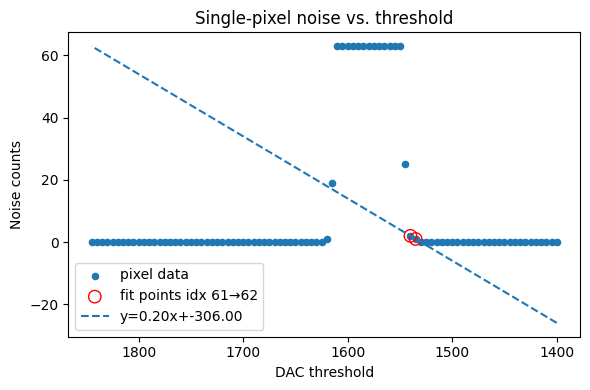

In [ ]:
plot_pixel_with_distinct_fit(numpy_data[50])


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def fit_line_after_value(x, y, target=63):
    """
    Find the last index where y == target, then fit a line through the next two points to its right.

    Parameters
    ----------
    x : array-like (1D) or torch.Tensor
        The threshold axis.
    y : array-like (1D) or torch.Tensor
        The pixel noise counts.
    target : number
        Which value to treat as the “peak” to scan for (default=63).

    Returns
    -------
    m : float
        Slope of the fitted line.
    b : float
        Intercept of the fitted line.
    i1, i2 : int
        Indices of the two data points used for fitting.
    """
    # convert to numpy
    if isinstance(y, torch.Tensor):
        y_np = y.detach().cpu().numpy()
    else:
        y_np = np.asarray(y)
    if isinstance(x, torch.Tensor):
        x_np = x.detach().cpu().numpy()
    else:
        x_np = np.asarray(x)

    if x_np.ndim != 1 or y_np.ndim != 1 or x_np.shape != y_np.shape:
        raise ValueError("x and y must both be 1D arrays of the same length.")

    # find all positions of the target value
    peaks = np.where(y_np == target)[0]
    if peaks.size == 0:
        raise ValueError(f"Value {target} not found in data.")
    last_peak = peaks.max()

    # candidate points immediately to the right
    i1 = last_peak + 1
    i2 = last_peak + 2
    if i2 >= len(y_np):
        raise ValueError("Not enough points after the last peak to fit a line.")

    # if the two picked points happen to have the same value, skip forward
    y1 = y_np[i1]
    y2 = y_np[i2]
    if y2 == y1:
        for j in range(i2+1, len(y_np)):
            if y_np[j] != y1:
                i2 = j
                y2 = y_np[j]
                break
        else:
            raise ValueError("All subsequent points are equal — cannot find a distinct second point.")

    x1, x2 = x_np[i1], x_np[i2]

    # compute slope & intercept
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1

    return m, b, i1, i2

def plot_pixel_after_peak_fit(y,
                              x=None,
                              x_start=1845,
                              x_end=1395,
                              x_step=-5,
                              target=63):
    """
    Scatter-plot a pixel’s noise vs threshold, then overlay the two-point fit
    immediately after the last `target` value.

    Parameters
    ----------
    y : array-like (1D) or torch.Tensor
        The pixel’s noise counts (length N).
    x : array-like (1D) or torch.Tensor, optional
        The threshold axis. If None, defaults to np.arange(x_start, x_end, x_step).
    x_start, x_end, x_step : ints
        Used only if x is None, to build the default axis.
    target : number
        Which plateau value to scan for before fitting (default=63).
    """
    # build or convert x
    if x is None:
        x = np.arange(x_start, x_end, x_step)
    if isinstance(x, torch.Tensor):
        x_np = x.detach().cpu().numpy()
    else:
        x_np = np.asarray(x)

    # do the fit
    m, b, i1, i2 = fit_line_after_value(x_np, y, target=target)

    # convert y for plotting
    if isinstance(y, torch.Tensor):
        y_np = y.detach().cpu().numpy()
    else:
        y_np = np.asarray(y)

    # plotting
    plt.figure(figsize=(6,4))
    plt.scatter(x_np, y_np, s=20, label="pixel data")

    # highlight the two fit points
    plt.scatter([x_np[i1], x_np[i2]],
                [y_np[i1], y_np[i2]],
                s=100,
                facecolors='none',
                edgecolors='C1',
                label=f"fit pts idx {i1}, {i2}")

    # draw fitted line
    x_line = np.array([x_np.min(), x_np.max()])
    y_line = m * x_line + b
    plt.plot(x_line, y_line, '--', label=f"fit: y={m:.2f}x+{b:.2f}")

    plt.xlabel("DAC threshold")
    plt.ylabel("Noise counts")
    plt.title(f"Line through 2 pts after last '{target}' plateau")
    plt.legend()
    plt.gca().invert_xaxis()   # keep high→low thresholds left→right
    plt.tight_layout()
    plt.show()


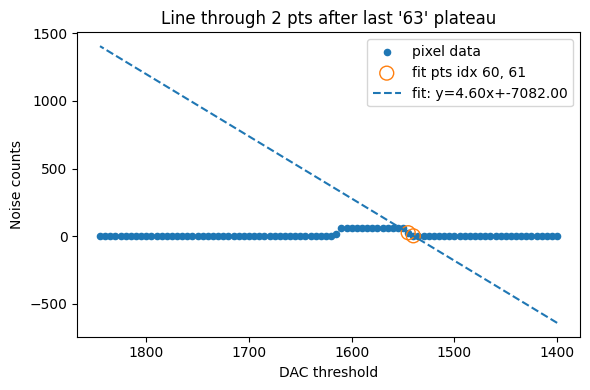

In [ ]:
plot_pixel_after_peak_fit(numpy_data[50])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_pixel_after_peak_fit_clipped(y,
                                      x=None,
                                      x_start=1845,
                                      x_end=1395,
                                      x_step=-5,
                                      target=63,
                                      y_min=0,
                                      y_max=65):
    """
    Scatter-plot a pixel’s noise vs threshold, then overlay the two-point
    fit (just after the last `target` plateau), clipped so 0 <= y <= 65.

    Parameters
    ----------
    y : array-like (1D) or torch.Tensor
        Pixel counts.
    x : array-like (1D) or torch.Tensor, optional
        Thresholds. If None, defaults to np.arange(x_start, x_end, x_step).
    target : number
        Value to look for (default=63).
    y_min, y_max : floats
        Vertical clipping bounds (default 0 and 65).
    """
    # --- build / convert x & y to numpy ---
    if x is None:
        x = np.arange(x_start, x_end, x_step)
    x_np = x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else np.asarray(x)
    y_np = y.detach().cpu().numpy() if isinstance(y, torch.Tensor) else np.asarray(y)

    # --- find last target, then next two distinct points ---
    peaks = np.where(y_np == target)[0]
    if peaks.size == 0:
        raise ValueError(f"Value {target} not found.")
    last_peak = peaks.max()
    i1, i2 = last_peak + 1, last_peak + 2
    if i2 >= len(y_np):
        raise ValueError("Not enough points after the last peak.")
    # skip identical values if needed
    if y_np[i2] == y_np[i1]:
        for j in range(i2+1, len(y_np)):
            if y_np[j] != y_np[i1]:
                i2 = j
                break
        else:
            raise ValueError("No distinct second point after peak.")
    x1, x2 = x_np[i1], x_np[i2]
    y1, y2 = y_np[i1], y_np[i2]

    # --- compute slope/intercept ---
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1

    # --- determine clipped segment endpoints ---
    # intersection with y = y_min and y = y_max
    if m == 0:
        # horizontal line: either inside [y_min,y_max] or skip
        if not (y_min <= b <= y_max):
            xs = np.empty((0,)); ys = np.empty((0,))
        else:
            xs = np.array([x_np.min(), x_np.max()])
            ys = np.full(2, b)
    else:
        x_at_min = (y_min - b) / m
        x_at_max = (y_max - b) / m
        # segment in x must lie in the intersection of:
        #   [x_np.min(), x_np.max()]  and  [x_at_min, x_at_max]
        lo = max(min(x_np), min(x_at_min, x_at_max))
        hi = min(max(x_np), max(x_at_min, x_at_max))
        if lo < hi:
            xs = np.array([lo, hi])
            ys = m * xs + b
        else:
            xs = np.empty((0,)); ys = np.empty((0,))

    # --- plot everything ---
    plt.figure(figsize=(6,4))
    plt.scatter(x_np, y_np, s=20, label="pixel data")
    plt.scatter([x_np[i1], x_np[i2]],
                [y1, y2],
                s=100, facecolors='none', edgecolors='C1',
                label=f"fit pts idx {i1},{i2}")
    if xs.size:
        plt.plot(xs, ys, '--', label=f"clipped fit\n$y={m:.2f}x+{b:.2f}$")
    plt.xlabel("DAC threshold")
    plt.ylabel("Noise counts")
    plt.title(f"Fit through two points after last “{target}”")
    plt.legend()
    plt.ylim(y_min, y_max)
    plt.gca().invert_xaxis()
    plt.tight_layout()
    plt.show()


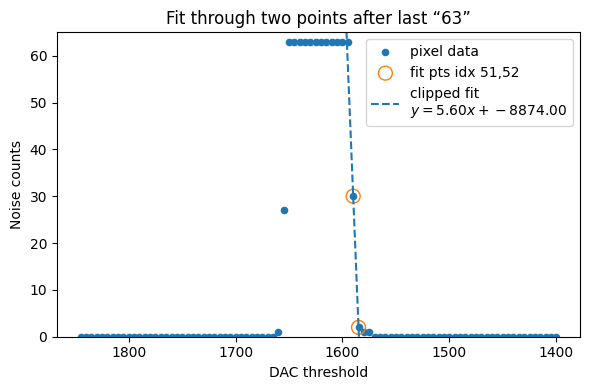

In [ ]:
plot_pixel_after_peak_fit_clipped(numpy_data[100])

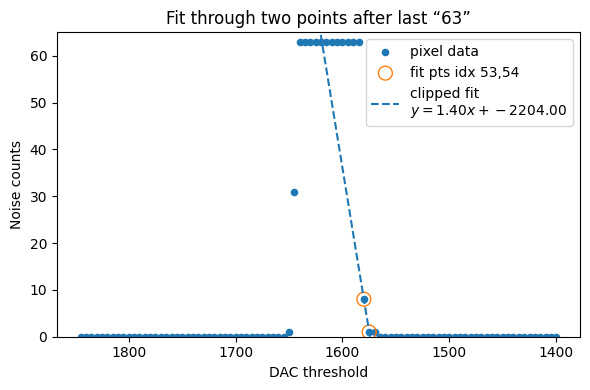

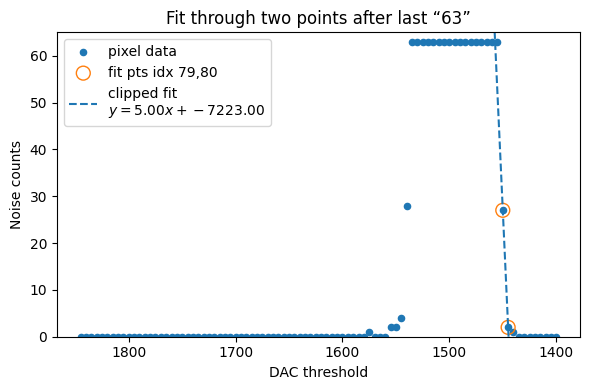

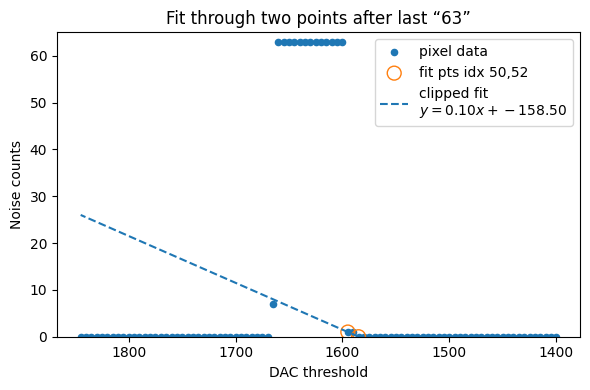

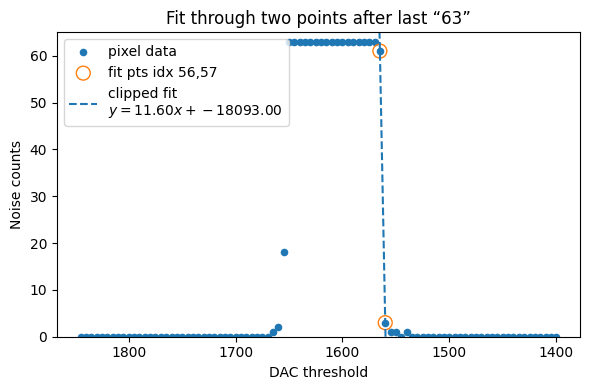

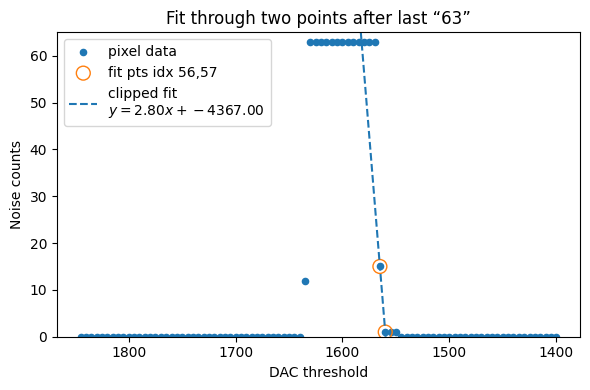

In [ ]:
for y in range(30,35):
  plot_pixel_after_peak_fit_clipped(numpy_data[y])

In [ ]:
def plot_pixel_with_crossing(y,
                             x=None,
                             x_start=1845,
                             x_end=1395,
                             x_step=-5,
                             target=63,
                             y_min=0,
                             y_max=65,
                             y_cross=31.5):
    """
    Plot pixel data vs threshold (default axis from 1845→1395 step −5),
    fit the line just after the last 'target' plateau, clip to [0,65],
    then mark where that line hits y=31.5 in purple.
    """
    # build or convert x
    if x is None:
        x_np = np.arange(x_start, x_end, x_step)
    else:
        x_np = x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else np.asarray(x)
    y_np = y.detach().cpu().numpy() if isinstance(y, torch.Tensor) else np.asarray(y)

    # find last target and next two distinct points
    peaks = np.where(y_np == target)[0]
    if peaks.size == 0:
        raise ValueError(f"Value {target} not found")
    last_peak = peaks.max()
    i1, i2 = last_peak+1, last_peak+2
    if i2 >= len(y_np):
        raise ValueError("Not enough data points after target")
    if y_np[i2] == y_np[i1]:
        for j in range(i2+1, len(y_np)):
            if y_np[j] != y_np[i1]:
                i2 = j
                break
        else:
            raise ValueError("No distinct second fit point")
    x1, x2 = x_np[i1], x_np[i2]
    y1, y2 = y_np[i1], y_np[i2]

    # fit line
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1

    # clip segment
    if m == 0:
        xs_seg = np.array([x_np.min(), x_np.max()]) if y_min <= b <= y_max else np.empty(0)
        ys_seg = np.full_like(xs_seg, b)
    else:
        x_at_min = (y_min - b) / m
        x_at_max = (y_max - b) / m
        lo = max(x_np.min(), min(x_at_min, x_at_max))
        hi = min(x_np.max(), max(x_at_min, x_at_max))
        if lo < hi:
            xs_seg = np.array([lo, hi])
            ys_seg = m * xs_seg + b
        else:
            xs_seg, ys_seg = np.empty(0), np.empty(0)

    # crossing point for y_cross
    x_cross = (y_cross - b) / m if m != 0 else np.nan
    x_int = int(np.round(x_cross))
    y_int = m*x_int + b

    # plot
    plt.figure(figsize=(6,4))
    plt.scatter(x_np, y_np, s=20, label="pixel data")
    plt.scatter([x1, x2], [y1, y2],
                s=80, facecolors='none', edgecolors='C1',
                label=f"fit pts idx {i1},{i2}")
    if xs_seg.size:
        plt.plot(xs_seg, ys_seg, '--', label=f"fit: y={m:.2f}x+{b:.2f}")
    if not np.isnan(x_cross):
        plt.scatter([x_int], [y_int], color='purple', s=100,
                    label=f"y={y_cross} → x≈{x_int}")
        plt.annotate(f"({x_int},{y_cross})",
                     xy=(x_int, y_cross),
                     xytext=(5,5),
                     textcoords='offset points',
                     color='purple')
    plt.xlabel("DAC threshold")
    plt.ylabel("Noise counts")
    plt.title("Pixel fit + crossing at y=31.5")
    plt.ylim(y_min, y_max)
    plt.gca().invert_xaxis()
    plt.legend()
    plt.tight_layout()
    plt.show()


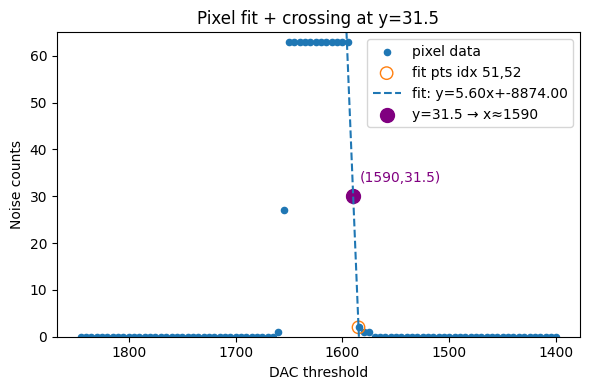

In [ ]:
plot_pixel_with_crossing(numpy_data[100])

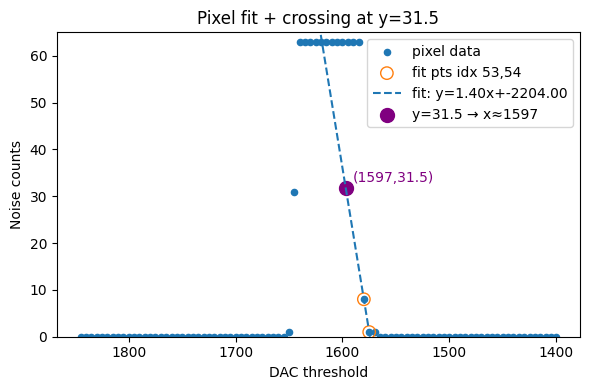

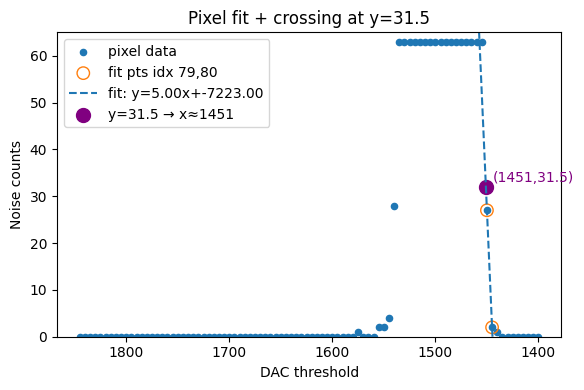

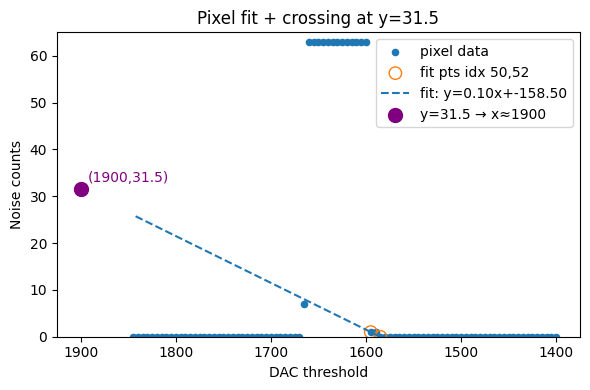

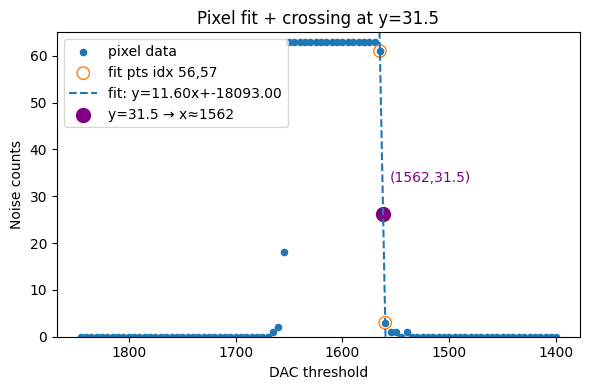

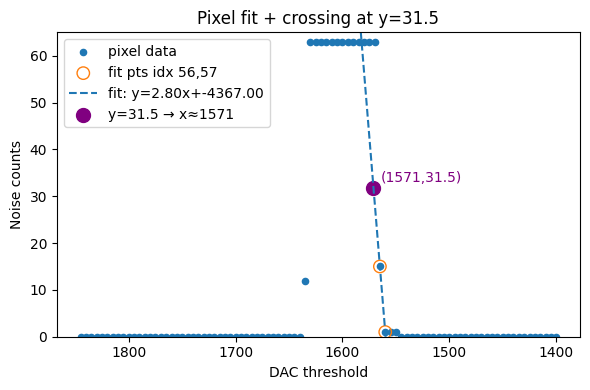

In [ ]:
for y in range(30, 35):
  plot_pixel_with_crossing(numpy_data[y])

In [ ]:
import numpy as np

def compute_crossings(numpy_data,
                      thr_axis=None,
                      x_start=1845,
                      x_end=1395,
                      x_step=-5,
                      target=63,
                      y_cross=31.5):
    """
    For each row in `numpy_data` (shape [n_pixels, n_thr]), fit the
    two-point line after the last `target` value and solve for x at y=y_cross.
    Returns a 1D array of ints (or nan) of length n_pixels.
    """
    # build default threshold axis if needed
    if thr_axis is None:
        thr_axis = np.arange(x_start, x_end, x_step)
    n_pix = numpy_data.shape[0]
    x_vals = np.full(n_pix, np.nan)

    for idx in range(n_pix):
        y = numpy_data[idx]
        # find all positions of the plateau
        peaks = np.where(y == target)[0]
        if peaks.size == 0:
            continue  # no fit possible

        last_peak = peaks.max()
        i1, i2 = last_peak+1, last_peak+2
        if i2 >= y.size:
            continue  # not enough points

        # skip over equal-value if needed
        if y[i2] == y[i1]:
            for j in range(i2+1, y.size):
                if y[j] != y[i1]:
                    i2 = j
                    break
            else:
                continue

        x1, x2 = thr_axis[i1], thr_axis[i2]
        y1, y2 = y[i1], y[i2]
        # compute slope/intercept
        m = (y2 - y1) / (x2 - x1)
        if m == 0:
            continue
        b = y1 - m * x1

        # solve for x at y_cross, round to int
        x_cross = (y_cross - b) / m
        x_vals[idx] = np.round(x_cross)

    return x_vals

# --- usage ---
# numpy_data is your (65536,90) array
crossings = compute_crossings(numpy_data)
# crossings is a 1D array of length 65536, dtype float (with nan where no fit)
# if you really want ints with a mask instead of nan:
# crossings_int = np.where(np.isnan(crossings), -1, crossings.astype(int))


In [ ]:
crossings

array([1533., 1542., 1588., ..., 1528., 1648., 1518.])

In [ ]:
# define bounds
min_thr, max_thr = 1450, 1700

# mask for “valid” thresholds (inside bounds, inclusive)
valid_mask = (crossings >= min_thr) & (crossings <= max_thr)
valid_thresholds = crossings[valid_mask]

# mask for “excluded” thresholds (outside those bounds)
excluded_mask = (crossings < min_thr) | (crossings > max_thr)
excluded_thresholds = crossings[excluded_mask]

print(f"{len(valid_thresholds)} valid thresholds, {len(excluded_thresholds)} excluded")


60998 valid thresholds, 4520 excluded


In [ ]:
if valid_thresholds.size > 0:
    avg_valid = np.mean(valid_thresholds)
    print(f"Average valid threshold: {avg_valid:.2f}")

Average valid threshold: 1579.31


TODO ideas:
1. Prepare a list of thresholds for each pixel (average threshold +- delta for a specific pixel)
2. Compare the result with the actual result (need actual data for this + preferably more data)
3. Analyze excluded pixel data (how many pixels are invalid, how their fitted functions look like etc.)
4. Test ML for this process

# Original Velo code

## Import data

In [ ]:
file_path = '/content/drive/MyDrive/magisterka/data_velopix/Module29_VP0-0_scan0_raw.csv'
data = np.loadtxt(fname=file_path, delimiter=",", skiprows=1)

In [ ]:
data.shape

(23040, 256)

## Essential analyze code

### Analyze class refactored

In [20]:
import time
import numpy as np
import glob as glob
import matplotlib.pyplot as plt


class Analyse():
    def __init__(
        self
    ):
        """
        """

    def threshold_scan(self, data, header, save = 1, slope = 'right', path = ''):
        print("Processing a threshold scan...")

        start = time.time()
        thr_range = np.arange(header.max_thr , header.min_thr , -header.step_size)
        data = data.astype(dtype = np.uint32).reshape((-1,256,256))
        d_mean, d_std = self.threshold_mean_std(data, thr_range)

        end = time.time()
        print("...time for computing mean & std is ", end - start)

        if save == 1:
            start = time.time()
            np.savetxt(path + header.vp + '_scan' + str(header.trim) + '_mean.csv', d_mean, delimiter = ',',
                    header = header.readable, fmt = '%.2f')
            np.savetxt(path + header.vp + '_scan' + str(header.trim) + '_std.csv', d_std, delimiter = ',',
                    header = header.readable, fmt = '%.2f')
            end = time.time()
            print("...saving mean & std, time elapsed: ", end - start)

        start = time.time()
        rate = self.threshold_rate(data, header.min_thr, header.max_thr, header.step_size, slope = slope)

        if save == 1:
            np.savetxt(path + header.vp + '_scan' + str(header.trim) + '_rate.csv', rate, delimiter = ',',
                    header = header.readable, fmt = '%.u')
        end = time.time()
        print("...computing noise rate, time elapsed: ", end - start)
        return d_mean, d_std, rate

    def generate_thr_recipe(self, dmean, header, cond, path = '') -> int:
        print(f"Generating threshold for {cond} DAC threshold ...")
        mdmean = np.mean(dmean, where = dmean != 0)
        thr = np.array([mdmean + cond])
        print(f'... computed threshold at {thr} DAC')
        np.savetxt(path + header.vp + '_threshold_recipe.csv', thr, fmt = '%.u')
        return thr

    def zeros(self, a, b):
        return np.zeros([a, b])

    def threshold_rate(self, data, min_thr, max_thr, step_size, slope = 'right'):
        if slope == 'left':
            data = np.flip(data, axis = 0)
        satmax = np.argmax(data > 31.5, axis = 0)
        #satmax[satmax == 0] = np.nan
        slopemax_l = np.float32(data[satmax, np.arange(256)[:, np.newaxis], np.arange(256)])
        slopemax_h = np.float32(data[satmax - 1, np.arange(256)[:, np.newaxis], np.arange(256)])
        grad = (slopemax_h - slopemax_l)/(step_size)
        if slope == 'right':
            dacmax = (max_thr - satmax * step_size)
        elif slope == 'left':
            dacmax = (min_thr + satmax * step_size)
        #satmax_dac[satmax_dac == 1950] = 0
        grad[grad == 0.0] = float('inf')
        slopemid = np.round(dacmax - (slopemax_l - 31.5)/grad)
        return slopemid

    def threshold_mean_std(self, data, thr_range):
        if data.dtype != np.uint32:
            data = data.astype(dtype = np.uint32)

        d_total = np.sum(data, axis = 0, dtype = np.float32)
        d_total[d_total == 0] = np.nan
        d_times_thr = data * thr_range[:, np.newaxis, np.newaxis]
        d_integral = np.sum(d_times_thr, axis = 0)
        d_mean = np.divide(d_integral, d_total)#, where = (d_total != 0))

        m_squared = np.array([np.full((256,256), thr) - d_mean for thr in thr_range]) ** 2
        d_times_squared = data * m_squared
        d_integral = np.sum(d_times_squared, axis = 0)
        d_sigma = np.sqrt(d_integral/d_total)

        d_mean = np.nan_to_num(d_mean, nan = 0)#.astype(np.uint32)
        d_sigma = np.nan_to_num(d_sigma, nan = 0)

        return d_mean, d_sigma


    def threshold_std(self, data, thr_range):
        if data.dtype != np.uint32:
            data = data.astype(dtype = np.uint32)
        m_squared = np.array([np.full((256,256), thr) - d_mean for thr in thr_range]) ** 2
        d_times_squared = data * m_squared
        d_integral = np.sum(d_times_squared, axis = 0)
        d_sigma = np.sqrt(d_integral / d_total)

    def mean_std(self, scan, precision = 2, skip_zeros = False):
        try:
            if skip_zeros == False:
                scan_mean = round(np.nanmean(scan), precision)
                scan_std = round(np.nanstd(scan), precision)
            else:
                scan_mean = round(np.nanmean(scan[scan!=0]), precision)
                scan_std = round(np.nanstd(scan[scan!=0]), precision)
        except:
            scan_mean, scan_std = np.nan, np.nan
        return scan_mean, scan_std


### Header and method calls

In [ ]:
from types import SimpleNamespace

header = SimpleNamespace(
    min_thr    = 1395,
    max_thr    = 1845,
    step_size  =   5,
    vp         = 'VP0-0',
    trim       =    0,
    readable   = 'DAC threshold scan for VP0-0'  # will go in the CSV header
)


In [ ]:
ana = Analyse()

out_folder = '/content/drive/MyDrive/magisterka/results_updated/'
import os
os.makedirs(out_folder, exist_ok=True)

# data saved to files: VP0-0_scan0_mean.csv, VP0-0_scan0_std.csv and VP0-0_scan0_rate.csv
d_mean, d_std, rate = ana.threshold_scan(
    data,
    header,
    save  = 1,
    slope = 'right',
    path  = out_folder
)


Processing a threshold scan...
...time for computing mean & std is  0.16459131240844727
...saving mean & std, time elapsed:  0.08286023139953613
...computing noise rate, time elapsed:  0.06624293327331543


In [ ]:
# For trim 0

# a single‐value threshold recipe (global DAC threshold)
thr = ana.generate_thr_recipe(d_mean, header, cond=20, path=out_folder)
# -> saved to file: VP0-0_threshold_recipe.csv

Generating threshold for 20 DAC threshold ...
... computed threshold at [1620.99447497] DAC


In [ ]:
print(f"d_mean:\n{d_mean}")
print("----------------------------")
print(f"d_std:\n{d_std}")
print("----------------------------")
print(f"rate:\n{rate}")
print("----------------------------")
print(f"thr:\n{thr}")

d_mean:
[[1559.50595238 1585.25288376 1590.7226792  ... 1584.97287523
  1652.60590501 1722.77620397]
 [1620.77326343 1602.9307026  1569.70588235 ... 1598.37980769
  1582.92954265 1619.05141844]
 [1572.15686275 1603.74765478 1600.54309327 ... 1603.09798271
  1574.42437923 1576.89153439]
 ...
 [1616.96911197 1594.38289602 1604.93429698 ... 1584.9015748
  1571.8240621  1622.89168279]
 [1582.80970626 1641.53656126 1630.80445545 ... 1595.71011673
  1566.9510665  1616.61713287]
 [1614.86077482 1609.76100629 1581.16883117 ... 1587.04530313
  1682.87547529 1571.90755208]]
----------------------------
d_std:
[[19.35323186 26.20736582 19.58981702 ... 25.47734494 17.93620176
  24.51778488]
 [17.62964613 24.04281172 21.85147648 ... 24.1179987  18.68703218
  26.05376699]
 [22.43997053 25.03380677 19.53261968 ... 24.1519765  20.54028782
  26.2184161 ]
 ...
 [17.99961599 24.11369931 17.69194397 ... 23.61602614 17.82036542
  23.76858671]
 [18.17218083 23.51174224 18.97030979 ... 23.85779072 18.6138563

## Updated neural network

In [ ]:
data.shape

(23040, 256)

### 1st iteration

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import tensorflow as tf
import matplotlib.pyplot as plt

# --- 1) Preprocessing ----------------------------------

# assume `data` is the raw counts array of shape (90*256, 256)
# and `rate` is the threshold map from ana.threshold_scan (shape 256×256)

# reshape raw into (90,256,256)
raw_counts = data.astype(np.uint32).reshape(-1, 256, 256)

# reorder to (256,256,90)
raw_counts = raw_counts.transpose(1, 2, 0)

# flatten pixels → (256*256, 90)
X = raw_counts.reshape(-1, 90)

# add channel dim → (num_pixels, 90, 1)
X = X[:, :, np.newaxis]

# targets y: flatten the rate map (256×256 → 65536,)
y = rate.reshape(-1)

# shuffle & split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(90, 1)),
    tf.keras.layers.Flatten(),          # → (90,)
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)            # output: predicted threshold
])

model.compile(
    optimizer='adam',
    loss='mse',                         # mean squared error
    metrics=['mae']                     # mean absolute error
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 90)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         5,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,937 (31.00 KB)

 Trainable params: 7,937 (31.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=1024,
    verbose=2
)

Epoch 1/20
52/52 - 2s - 34ms/step - loss: 1891840.0000 - mae: 1355.5035 - val_loss: 680566.3750 - val_mae: 812.3969
Epoch 2/20
52/52 - 0s - 5ms/step - loss: 158801.7344 - mae: 319.0800 - val_loss: 65127.9805 - val_mae: 207.8562
Epoch 3/20
52/52 - 0s - 6ms/step - loss: 64646.7383 - mae: 207.6234 - val_loss: 59090.2266 - val_mae: 199.3406
Epoch 4/20
52/52 - 0s - 5ms/step - loss: 57105.4922 - mae: 195.6414 - val_loss: 49898.1875 - val_mae: 183.8298
Epoch 5/20
52/52 - 0s - 6ms/step - loss: 45612.5234 - mae: 174.9679 - val_loss: 36922.8086 - val_mae: 158.0088
Epoch 6/20
52/52 - 0s - 6ms/step - loss: 31370.9746 - mae: 144.0721 - val_loss: 22760.4727 - val_mae: 122.8053
Epoch 7/20
52/52 - 1s - 11ms/step - loss: 17650.6602 - mae: 105.5517 - val_loss: 11162.4277 - val_mae: 84.1796
Epoch 8/20
52/52 - 0s - 5ms/step - loss: 8456.5762 - mae: 69.7396 - val_loss: 5006.3701 - val_mae: 54.2913
Epoch 9/20
52/52 - 0s - 6ms/step - loss: 4146.7002 - mae: 45.5741 - val_loss: 2506.9697 - val_mae: 36.5973
Epo

Test MSE: 1067.50, Test MAE: 14.18
Test R²: 0.206


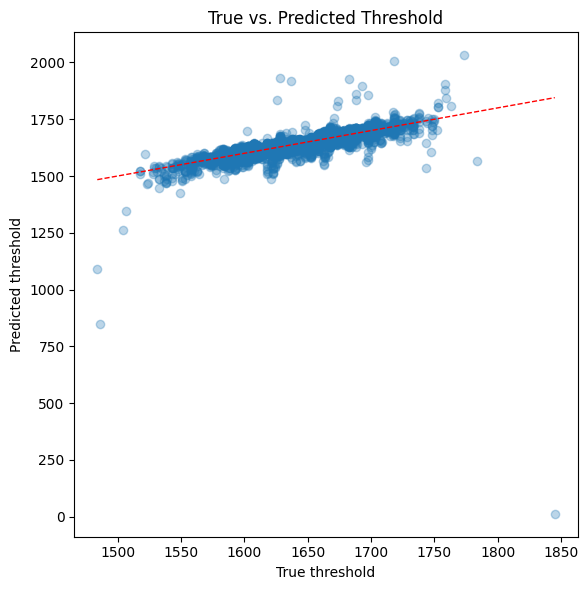

In [ ]:
mse, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MSE: {mse:.2f}, Test MAE: {mae:.2f}")

# b) R² score
y_pred = model.predict(X_test, verbose=0).flatten()
r2 = r2_score(y_test, y_pred)
print(f"Test R²: {r2:.3f}")

# c) Quick scatter plot of true vs predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', linewidth=1)
plt.xlabel('True threshold')
plt.ylabel('Predicted threshold')
plt.title('True vs. Predicted Threshold')
plt.tight_layout()
plt.show()

### 2nd iteration

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# 1a) Normalize each 90-frame series to [0,1]
#    (or you can standardize to zero mean/unit variance)
scaler_X = MinMaxScaler()
# reshape X_train: (n_pixels, 90, 1) → (n_pixels, 90)
X_train_flat = X_train.reshape(-1, 90)
X_train_scaled = scaler_X.fit_transform(X_train_flat).reshape(-1, 90, 1)
X_test_flat  = X_test.reshape(-1, 90)
X_test_scaled  = scaler_X.transform(X_test_flat).reshape(-1, 90, 1)

# 1b) Normalize y to [0,1]
y_min, y_max = y_train.min(), y_train.max()
y_train_scaled = (y_train - y_min) / (y_max - y_min)
y_test_scaled  = (y_test  - y_min) / (y_max - y_min)

y_pred_scaled = model.predict(X_test_scaled)
y_pred = y_pred_scaled * (y_max - y_min) + y_min


205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Input, Dense
from tensorflow.keras.models import Sequential

model = Sequential([
    Input(shape=(90,1)),
    Conv1D(32, kernel_size=5, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='linear'),
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 90, 32)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 45, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 45, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 22, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 22, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,361 (75.63 KB)

 Trainable params: 19,361 (75.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6, monitor='val_loss')
]

history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=7,
    batch_size=1024,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=2
)


Epoch 1/7
52/52 - 15s - 297ms/step - loss: 0.0699 - mae: 0.2039 - val_loss: 0.0093 - val_mae: 0.0757 - learning_rate: 1.0000e-03
Epoch 2/7
52/52 - 19s - 357ms/step - loss: 0.0094 - mae: 0.0755 - val_loss: 0.0016 - val_mae: 0.0303 - learning_rate: 1.0000e-03
Epoch 3/7
52/52 - 22s - 419ms/step - loss: 0.0045 - mae: 0.0527 - val_loss: 9.0060e-04 - val_mae: 0.0222 - learning_rate: 1.0000e-03
Epoch 4/7
52/52 - 20s - 385ms/step - loss: 0.0030 - mae: 0.0430 - val_loss: 5.1299e-04 - val_mae: 0.0172 - learning_rate: 1.0000e-03
Epoch 5/7
52/52 - 21s - 396ms/step - loss: 0.0022 - mae: 0.0363 - val_loss: 3.3861e-04 - val_mae: 0.0121 - learning_rate: 1.0000e-03
Epoch 6/7
52/52 - 12s - 224ms/step - loss: 0.0017 - mae: 0.0315 - val_loss: 2.2373e-04 - val_mae: 0.0096 - learning_rate: 1.0000e-03
Epoch 7/7
52/52 - 19s - 365ms/step - loss: 0.0013 - mae: 0.0279 - val_loss: 1.4733e-04 - val_mae: 0.0088 - learning_rate: 1.0000e-03


In [ ]:
test_mse, test_mae = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print(f"Test MSE: {test_mse:.4f}, Test MAE: {test_mae:.4f}")

Test MSE: 0.0002, Test MAE: 0.0086


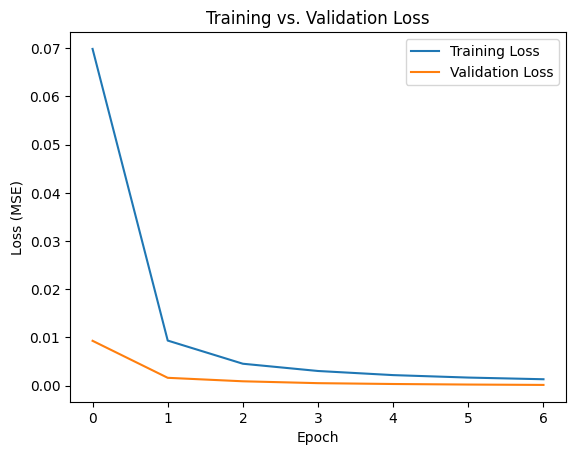

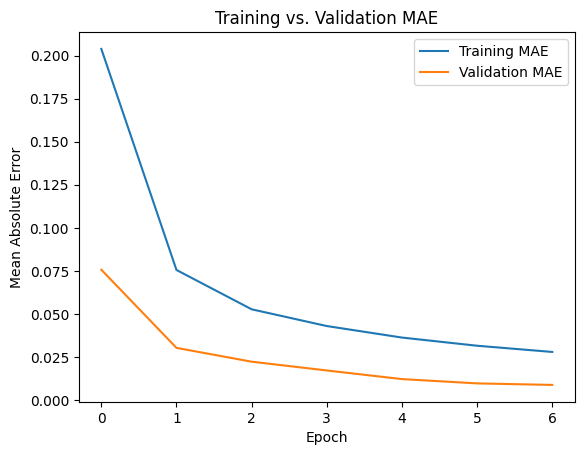

In [ ]:
import matplotlib.pyplot as plt

# 1) Loss curve
plt.figure()
plt.plot(history.history['loss'],    label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()

# 2) MAE curve
plt.figure()
plt.plot(history.history['mae'],     label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('Training vs. Validation MAE')
plt.legend()
plt.show()


In [ ]:
test_mse, test_mae = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print("Test   MSE (scaled):", test_mse, "  MAE (scaled):", test_mae)

# back-transform MAE to DAC units
y_pred_s = model.predict(X_test_scaled).flatten()
y_pred   = y_pred_s * (y_max - y_min) + y_min
y_true   = y_test_scaled * (y_max - y_min) + y_min

from sklearn.metrics import mean_absolute_error, r2_score
print("Test   MAE (DAC):", mean_absolute_error(y_true, y_pred))
print("Test   R²:",           r2_score(y_true, y_pred))


Test   MSE (scaled): 0.0001654900552239269   MAE (scaled): 0.008605911396443844
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Test   MAE (DAC): 3.8124175743791873
Test   R²: 0.9758547234755128


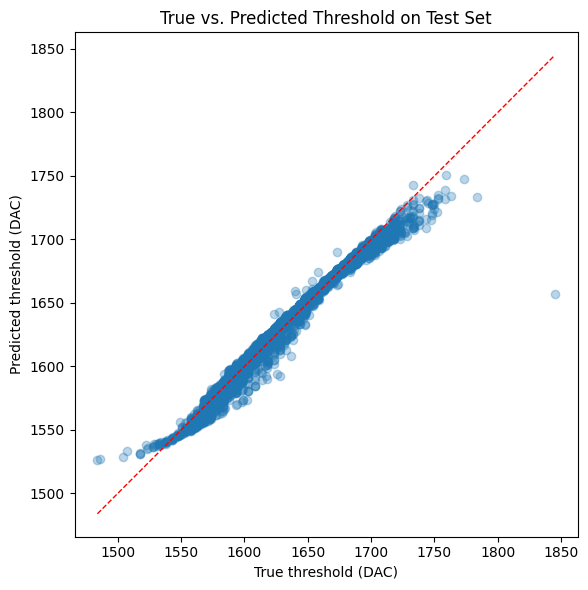

In [ ]:
# --- 1) Predict on the test set (scaled → back to DAC) ---
y_pred_scaled = model.predict(X_test_scaled, verbose=0).flatten()

# back-transform into original DAC units
y_pred = y_pred_scaled * (y_max - y_min) + y_min
y_true = y_test_scaled * (y_max - y_min) + y_min

# --- 2) Scatter plot in DAC units ---
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.3)
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         'r--', linewidth=1)
plt.xlabel('True threshold (DAC)')
plt.ylabel('Predicted threshold (DAC)')
plt.title('True vs. Predicted Threshold on Test Set')
plt.tight_layout()
plt.show()


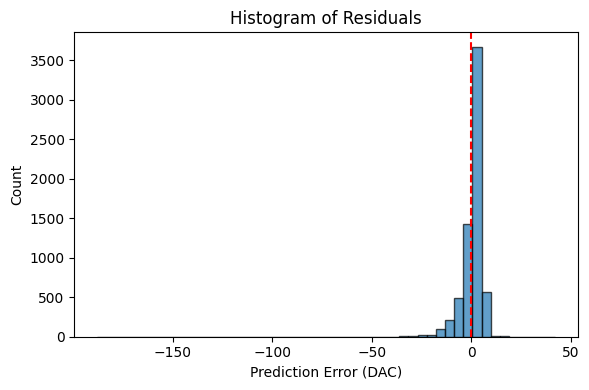

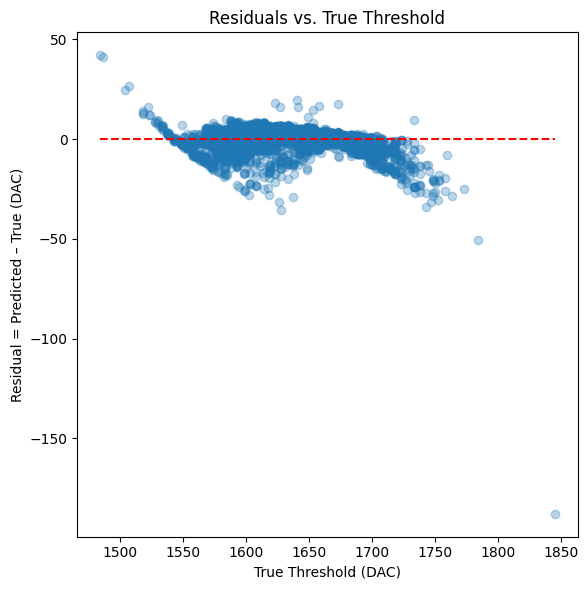

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

# — 1) Residual histogram —
# assume y_true and y_pred are in DAC units from your test set
residuals = y_pred - y_true

plt.figure(figsize=(6,4))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Prediction Error (DAC)')
plt.ylabel('Count')
plt.title('Histogram of Residuals')
plt.axvline(0, color='r', linestyle='--')
plt.tight_layout()
plt.show()


# — 2) Error vs. True Threshold —
plt.figure(figsize=(6,6))
plt.scatter(y_true, residuals, alpha=0.3)
plt.hlines(0, y_true.min(), y_true.max(), colors='r', linestyles='--')
plt.xlabel('True Threshold (DAC)')
plt.ylabel('Residual = Predicted – True (DAC)')
plt.title('Residuals vs. True Threshold')
plt.tight_layout()
plt.show()

## Add data from other sensors and adjust algorithm to various data length

In [32]:
# 1395 1845
file_path_1 = '/content/drive/MyDrive/magisterka/data_velopix/Module29_VP0-0_scan0_raw.csv'
velopix_data_1 = np.loadtxt(fname=file_path_1, delimiter=",", skiprows=1)

# 1235 1790
file_path_2 = '/content/drive/MyDrive/magisterka/data_velopix/Module00_VP3-1_scan0_raw_1of1.csv'
velopix_data_2 = np.loadtxt(fname=file_path_2, delimiter=",", skiprows=1)

# 1290 1885
file_path_3 = '/content/drive/MyDrive/magisterka/data_velopix/Module00_VP3-0_scan0_raw_1of1.csv'
velopix_data_3 = np.loadtxt(fname=file_path_3, delimiter=",", skiprows=1)

# 1340 1980
file_path_4 = '/content/drive/MyDrive/magisterka/data_velopix/Module00_VP2-2_scan0_raw_1of1.csv'
velopix_data_4 = np.loadtxt(fname=file_path_4, delimiter=",", skiprows=1)

# 1195 1780
file_path_5 = '/content/drive/MyDrive/magisterka/data_velopix/Module00_VP2-1_scan0_raw_1of1.csv'
velopix_data_5 = np.loadtxt(fname=file_path_5, delimiter=",", skiprows=1)

# 1145 1705
file_path_6 = '/content/drive/MyDrive/magisterka/data_velopix/Module00_VP3-2_scan0_raw_1of1.csv'
velopix_data_6 = np.loadtxt(fname=file_path_6, delimiter=",", skiprows=1)

In [55]:
velopix_data_6.shape

(28672, 256)

In [4]:
import numpy as np

def load_and_pad_stack(file_path: str,
                       sensor_max: int,
                       sensor_min: int,
                       global_max: int = 1980,
                       global_min: int = 1095,
                       step: int = 5) -> np.ndarray:
    """
    - Loads a raw scan CSV from `file_path`.
    - Reshapes it to (n_sensor_thr, 256, 256).
    - Pads the threshold axis up to the global range (global_max → global_min) so it becomes (n_global_thr, 256, 256).
    - Flattens the threshold & row axes into one: returns shape (n_global_thr * 256, 256).
    """
    # 1) load raw vector
    raw = np.loadtxt(fname=file_path, delimiter=",", skiprows=1)

    # 2) compute sensor & global threshold counts
    # Global thresholds should be adjusted to a specific sensor (to add the same amount of 0's on both ends - included for trim 15 data)
    n_sensor_thr = int((sensor_max - sensor_min) // step)
    n_global_thr = int((global_max - global_min) // step)

    # 3) reshape into (threshold, Y, X)
    data3d = raw.reshape(n_sensor_thr, 256, 256)

    # 4) allocate padded array and copy in sensor data
    padded = np.zeros((n_global_thr, 256, 256), dtype=data3d.dtype)
    start_idx = int((global_max - sensor_max) // step)
    padded[start_idx : start_idx + n_sensor_thr, :, :] = data3d

    # 5) flatten threshold & Y into rows, keep X as columns
    #    → shape (n_global_thr * 256, 256)
    return padded.reshape(n_global_thr * 256, 256)


In [9]:
normalized_stack_1 = load_and_pad_stack(
    file_path_1, sensor_max=1845, sensor_min=1395
)

normalized_stack_2 = load_and_pad_stack(
    file_path_2, sensor_max=1790, sensor_min=1235
)

normalized_stack_3 = load_and_pad_stack(
    file_path_3, sensor_max=1885, sensor_min=1290
)

normalized_stack_4 = load_and_pad_stack(
    file_path_4, sensor_max=1980, sensor_min=1340
)

normalized_stack_5 = load_and_pad_stack(
    file_path_5, sensor_max=1780, sensor_min=1195
)

normalized_stack_6 = load_and_pad_stack(
    file_path_6, sensor_max=1705, sensor_min=1145
)


In [37]:
print(normalized_stack_4.shape)   # → (177*256, 256)

(45312, 256)


In [41]:
from types import SimpleNamespace

header = SimpleNamespace(
    min_thr    = 1095,
    max_thr    = 1980,
    step_size  =   5,
    vp         = 'VP2-2',
    trim       =    0,
    readable   = 'DAC threshold scan for VP2-2'  # will go in the CSV header
)
ana = Analyse()

out_folder = '/content/drive/MyDrive/magisterka/results_updated/'
import os
os.makedirs(out_folder, exist_ok=True)

# data saved to files: VP2-2_scan0_mean.csv, VP2-2_scan0_std.csv and VP2-2_scan0_rate.csv
d_mean, d_std, rate = ana.threshold_scan(
    normalized_stack_4,
    header,
    save  = 1,
    slope = 'right',
    path  = out_folder
)

Processing a threshold scan...
...time for computing mean & std is  0.33243441581726074
...saving mean & std, time elapsed:  0.5568115711212158
...computing noise rate, time elapsed:  0.3781118392944336


In [45]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Input, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# --- 1) Preprocessing ----------------------------------

# assume `stack` is the padded stack array of shape (177*256, 256),
# and `rate` is the threshold map from ana.threshold_scan (shape 256×256)

# reshape raw into (177,256,256)
raw_counts = normalized_stack_4.astype(np.uint32).reshape(177, 256, 256)

# reorder to (256,256,177)
raw_counts = raw_counts.transpose(1, 2, 0)

# flatten pixels → (256*256, 177)
X = raw_counts.reshape(-1, 177)

# add channel dim → (num_pixels, 177, 1)
X = X[:, :, np.newaxis]

# targets y: flatten the rate map (256×256 → 65536,)
y = rate.reshape(-1)

# shuffle & split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

# 1a) Normalize each 177-frame series to [0,1]
scaler_X = MinMaxScaler()
X_train_flat    = X_train.reshape(-1, 177)
X_train_scaled  = scaler_X.fit_transform(X_train_flat).reshape(-1, 177, 1)
X_test_flat     = X_test.reshape(-1, 177)
X_test_scaled   = scaler_X.transform(X_test_flat).reshape(-1, 177, 1)

# 1b) Normalize y to [0,1]
y_min, y_max    = y_train.min(), y_train.max()
y_train_scaled  = (y_train - y_min) / (y_max - y_min)
y_test_scaled   = (y_test  - y_min) / (y_max - y_min)

# --- 2) Build & compile model -----------------------

model = Sequential([
    Input(shape=(177, 1)),              # <-- updated length
    Conv1D(32, kernel_size=5, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='linear'),
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# --- 3) Train ----------------------------------------

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6, monitor='val_loss')
]

history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=9,
    batch_size=1024,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=2
)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 177, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 88, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 88, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 44, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 44, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,361 (75.63 KB)

 Trainable params: 19,361 (75.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/9
52/52 - 25s - 487ms/step - loss: 0.0232 - mae: 0.1150 - val_loss: 0.0067 - val_mae: 0.0645 - learning_rate: 1.0000e-03
Epoch 2/9
52/52 - 41s - 794ms/step - loss: 0.0036 - mae: 0.0463 - val_loss: 0.0011 - val_mae: 0.0245 - learning_rate: 1.0000e-03
Epoch 3/9
52/52 - 41s - 788ms/step - loss: 0.0015 - mae: 0.0299 - val_loss: 5.7024e-04 - val_mae: 0.0180 - learning_rate: 1.0000e-03
Epoch 4/9
52/52 - 43s - 828ms/step - loss: 0.0011 - mae: 0.0254 - val_loss: 2.9158e-04 - val_mae: 0.0126 - learning_rate: 1.0000e-03
Epoch 5/9
52/52 - 41s - 786ms/step - loss: 7.6024e-04 - mae: 0.0213 - val_loss: 8.7217e-05 - val_mae: 0.0064 - learning_rate: 1.0000e-03
Epoch 6/9
52/52 - 40s - 778ms/step - loss: 5.7456e-04 - mae: 0.0184 - val_loss: 6.5836e-05 - val_mae: 0.0046 - learning_rate: 1.0000e-03
Epoch 7/9
52/52 - 22s - 421ms/step - loss: 4.6170e-04 - mae: 0.0164 - val_loss: 5.4858e-05 - val_mae: 0.0050 - learning_rate: 1.0000e-03
Epoch 8/9
52/52 - 41s - 785ms/step - loss: 3.7763e-04 - mae: 0.01

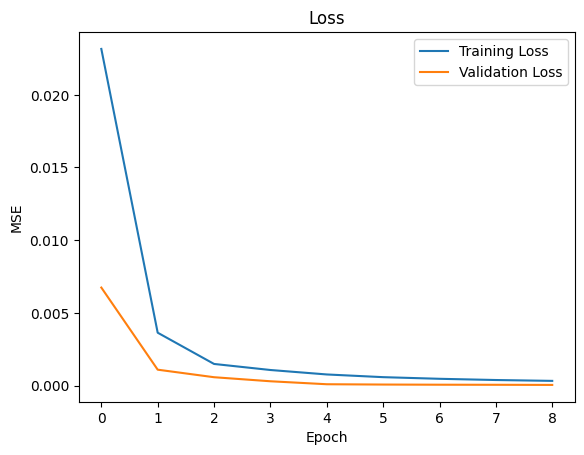

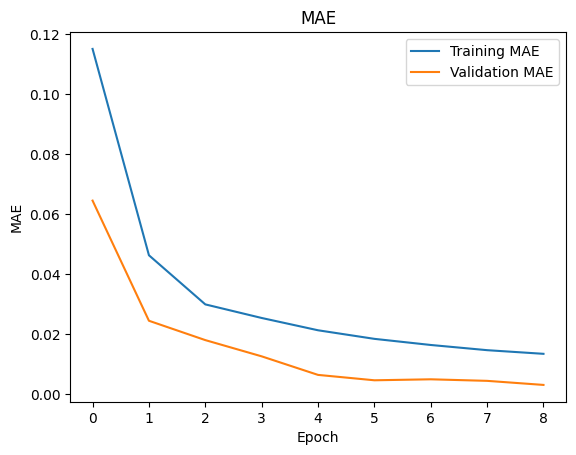

Test   MSE (scaled): 2.9954389901831746e-05   MAE (scaled): 0.0029226026963442564
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Test   MAE (DAC): 1.6541926692744964
Test   R²: 0.9950970013272746


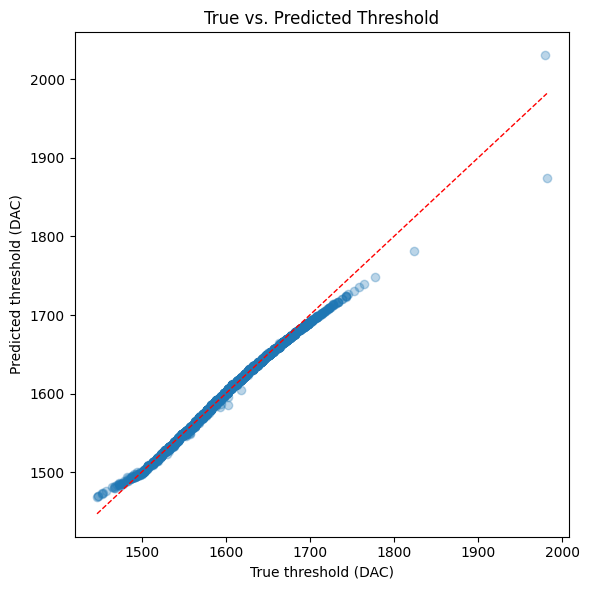

In [46]:
# --- 4) Evaluate & plot -----------------------------

# Loss / MAE curves
plt.figure()
plt.plot(history.history['loss'],    label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.legend(); plt.title('Loss')
plt.show()

plt.figure()
plt.plot(history.history['mae'],     label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch'); plt.ylabel('MAE'); plt.legend(); plt.title('MAE')
plt.show()

# Metrics on test set
test_mse, test_mae = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print("Test   MSE (scaled):", test_mse, "  MAE (scaled):", test_mae)

# Back-transform predictions to DAC units
y_pred_scaled = model.predict(X_test_scaled).flatten()
y_pred        = y_pred_scaled * (y_max - y_min) + y_min
y_true        = y_test_scaled * (y_max - y_min) + y_min

print("Test   MAE (DAC):", mean_absolute_error(y_true, y_pred))
print("Test   R²:",           r2_score(y_true, y_pred))

# Scatter plot True vs. Predicted
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.3)
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         'r--', linewidth=1)
plt.xlabel('True threshold (DAC)')
plt.ylabel('Predicted threshold (DAC)')
plt.title('True vs. Predicted Threshold')
plt.tight_layout()
plt.show()


### Test neural network on other sensors

In [47]:
from types import SimpleNamespace

header = SimpleNamespace(
    min_thr    = 1095,
    max_thr    = 1980,
    step_size  =   5,
    vp         = 'VP2-1',
    trim       =    0,
    readable   = 'DAC threshold scan for VP2-1'  # will go in the CSV header
)
ana = Analyse()

# out_folder = '/content/drive/MyDrive/magisterka/results_updated/'
# import os
# os.makedirs(out_folder, exist_ok=True)

d_mean_5, d_std_5, rate_5 = ana.threshold_scan(
    normalized_stack_5,
    header,
    save  = 1,
    slope = 'right',
    path  = out_folder
)

Processing a threshold scan...
...time for computing mean & std is  0.5469357967376709
...saving mean & std, time elapsed:  0.07092809677124023
...computing noise rate, time elapsed:  0.07765603065490723


Stack 5  MAE (DAC): 3.61
Stack 5  R²:          0.971


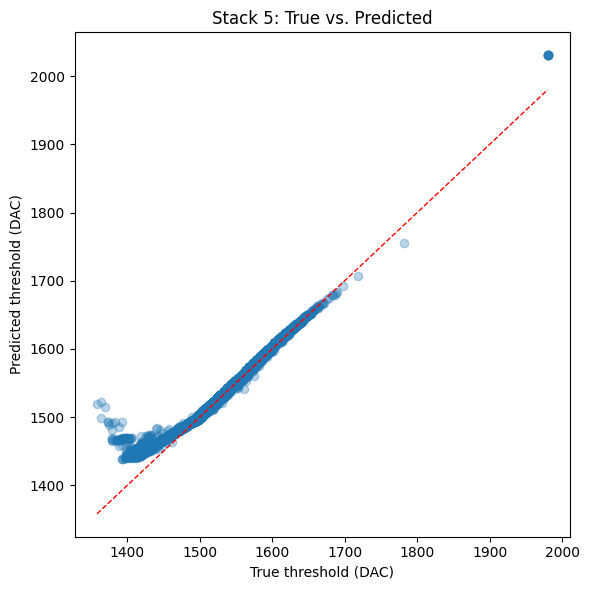

In [48]:
# --- Prep the inputs for stack 5 -------------------

# 1) reshape into (177,256,256)
raw_counts_5 = normalized_stack_5.astype(np.uint32).reshape(177, 256, 256)

# 2) reorder to (256,256,177)
raw_counts_5 = raw_counts_5.transpose(1, 2, 0)

# 3) flatten to (256*256, 177) and add channel dim → (n_pixels, 177, 1)
X5 = raw_counts_5.reshape(-1, 177)[:, :, np.newaxis]

# 4) scale with the SAME scaler_X you used for training
X5_flat   = X5.reshape(-1, 177)
X5_scaled = scaler_X.transform(X5_flat).reshape(-1, 177, 1)

# --- Prepare the true targets ----------------------

y5 = rate_5.reshape(-1)
y5_scaled = (y5 - y_min) / (y_max - y_min)

# --- Run inference & metrics ----------------------

# 1) get scaled preds
y5_pred_scaled = model.predict(X5_scaled, verbose=0).flatten()

# 2) back‐transform to DAC units
y5_pred = y5_pred_scaled * (y_max - y_min) + y_min

# 3) compute error metrics
from sklearn.metrics import mean_absolute_error, r2_score
mae5 = mean_absolute_error(y5, y5_pred)
r2_5 = r2_score(y5, y5_pred)

print(f"Stack 5  MAE (DAC): {mae5:.2f}")
print(f"Stack 5  R²:          {r2_5:.3f}")

# --- Optional: scatter plot ------------------------

import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y5, y5_pred, alpha=0.3)
plt.plot([y5.min(), y5.max()],
         [y5.min(), y5.max()],
         'r--', linewidth=1)
plt.xlabel('True threshold (DAC)')
plt.ylabel('Predicted threshold (DAC)')
plt.title('Stack 5: True vs. Predicted')
plt.tight_layout()
plt.show()


VP3-2 (normalized_6)

In [51]:
from types import SimpleNamespace

header = SimpleNamespace(
    min_thr    = 1095,
    max_thr    = 1980,
    step_size  =   5,
    vp         = 'VP3-2',
    trim       =    0,
    readable   = 'DAC threshold scan for VP3-2'  # will go in the CSV header
)
ana = Analyse()

# out_folder = '/content/drive/MyDrive/magisterka/results_updated/'
# import os
# os.makedirs(out_folder, exist_ok=True)

d_mean_6, d_std_6, rate_6 = ana.threshold_scan(
    normalized_stack_6,
    header,
    save  = 1,
    slope = 'right',
    path  = out_folder
)

Processing a threshold scan...
...time for computing mean & std is  0.3475511074066162
...saving mean & std, time elapsed:  0.06582450866699219
...computing noise rate, time elapsed:  0.1046297550201416


Stack 6  MAE (DAC): 20.85
Stack 6  R²:          0.394


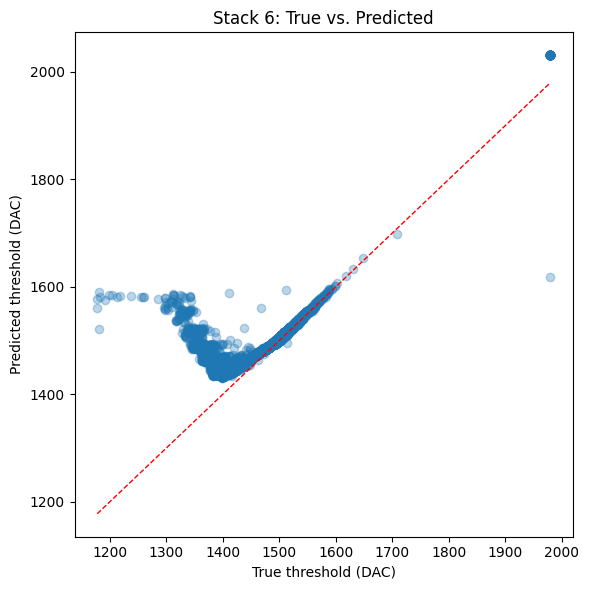

In [52]:
# --- Prep the inputs for stack 6 -------------------

# 1) reshape into (177,256,256)
raw_counts_6 = normalized_stack_6.astype(np.uint32).reshape(177, 256, 256)

# 2) reorder to (256,256,177)
raw_counts_6 = raw_counts_6.transpose(1, 2, 0)

# 3) flatten to (256*256, 177) and add channel dim → (n_pixels, 177, 1)
X6 = raw_counts_6.reshape(-1, 177)[:, :, np.newaxis]

# 4) scale with the SAME scaler_X you used for training
X6_flat     = X6.reshape(-1, 177)
X6_scaled   = scaler_X.transform(X6_flat).reshape(-1, 177, 1)

# --- Prepare the true targets ----------------------

y6          = rate_6.reshape(-1)
y6_scaled   = (y6 - y_min) / (y_max - y_min)

# --- Run inference & metrics ----------------------

# 1) get scaled preds
y6_pred_scaled = model.predict(X6_scaled, verbose=0).flatten()

# 2) back-transform to DAC units
y6_pred        = y6_pred_scaled * (y_max - y_min) + y_min

# 3) compute error metrics
from sklearn.metrics import mean_absolute_error, r2_score
mae6 = mean_absolute_error(y6, y6_pred)
r2_6 = r2_score(y6, y6_pred)

print(f"Stack 6  MAE (DAC): {mae6:.2f}")
print(f"Stack 6  R²:          {r2_6:.3f}")

# --- Optional: scatter plot ------------------------

plt.figure(figsize=(6,6))
plt.scatter(y6, y6_pred, alpha=0.3)
plt.plot([y6.min(), y6.max()],
         [y6.min(), y6.max()],
         'r--', linewidth=1)
plt.xlabel('True threshold (DAC)')
plt.ylabel('Predicted threshold (DAC)')
plt.title('Stack 6: True vs. Predicted')
plt.tight_layout()
plt.show()


In [53]:
reshaped_data = normalized_stack_6.reshape(177, 256, 256)
transposed_data = reshaped_data.transpose(1, 2, 0)
np_data = transposed_data.reshape(65536, 177)
tensors_data = torch.Tensor(np_data)
tensors_data.shape

torch.Size([65536, 177])

In [54]:
# zeroes have been added to the start, due to the initial global thresholds on pad method
tensors_data[5]

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  9., 63., 63., 63., 63., 63.,
        63., 63., 63., 63., 63., 63., 63., 11.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [56]:
reshaped_data = velopix_data_6.reshape(112, 256, 256)
transposed_data = reshaped_data.transpose(1, 2, 0)
np_data = transposed_data.reshape(65536, 112)
tensors_data = torch.Tensor(np_data)
tensors_data.shape

torch.Size([65536, 112])

In [57]:
tensors_data[5]

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  9., 63., 63., 63., 63.,
        63., 63., 63., 63., 63., 63., 63., 63., 11.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

check data 2

In [10]:
reshaped_data = normalized_stack_2.reshape(177, 256, 256)
transposed_data = reshaped_data.transpose(1, 2, 0)
np_data = transposed_data.reshape(65536, 177)
tensors_data = torch.Tensor(np_data)
tensors_data.shape
tensors_data[5]

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  4., 63., 63., 63., 63., 63., 63., 63., 63., 63.,
        63., 63., 63., 63.,  4.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [7]:
reshaped_data = velopix_data_2.reshape(111, 256, 256)
transposed_data = reshaped_data.transpose(1, 2, 0)
np_data = transposed_data.reshape(65536, 111)
tensors_data = torch.Tensor(np_data)
tensors_data.shape
tensors_data[5]

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4., 63., 63., 63., 63., 63.,
        63., 63., 63., 63., 63., 63., 63., 63.,  4.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

### Try to fix sensor 6 results

In [35]:
gmax, gmin = compute_global_range_centered(
    sensor_min=1145,
    sensor_max=1705,
    total_steps=177,
    step_size=5
)
print(f"gmax: {gmax}, gmin: {gmin}")

gmax: 1865, gmin: 980


# Create and test model for trim 15 data

In [11]:
# 1465 1925
file_path_1_trim_15 = '/content/drive/MyDrive/magisterka/data_velopix/trim15/Module00_VP0-0_scan15_raw_1of1.csv'
_trim_15_data_1 = np.loadtxt(fname=file_path_1_trim_15, delimiter=",", skiprows=1)

# 1425 1885
file_path_2_trim_15 = '/content/drive/MyDrive/magisterka/data_velopix/trim15/Module00_VP0-1_scan15_raw_1of1.csv'
_trim_15_data_2 = np.loadtxt(fname=file_path_2_trim_15, delimiter=",", skiprows=1)

# 1430 1880
file_path_3_trim_15 = '/content/drive/MyDrive/magisterka/data_velopix/trim15/Module00_VP0-2_scan15_raw_1of1.csv'
_trim_15_data_3 = np.loadtxt(fname=file_path_3_trim_15, delimiter=",", skiprows=1)

# 1420 1860
file_path_4_trim_15 = '/content/drive/MyDrive/magisterka/data_velopix/trim15/Module00_VP1-0_scan15_raw_1of1.csv'
_trim_15_data_4 = np.loadtxt(fname=file_path_4_trim_15, delimiter=",", skiprows=1)

# 1380 1820
file_path_5_trim_15 = '/content/drive/MyDrive/magisterka/data_velopix/trim15/Module00_VP1-1_scan15_raw_1of1.csv'
_trim_15_data_5 = np.loadtxt(fname=file_path_5_trim_15, delimiter=",", skiprows=1)

# 1600 1980
file_path_6_trim_15 = '/content/drive/MyDrive/magisterka/data_velopix/trim15/Module00_VP1-2_scan15_raw_1of1.csv'
_trim_15_data_6 = np.loadtxt(fname=file_path_6_trim_15, delimiter=",", skiprows=1)

In [13]:
_trim_15_data_5.shape

(22528, 256)

In [14]:
import numpy as np
import math

# Updated global range calculate method
def compute_global_range_centered(sensor_min: int,
                                  sensor_max: int,
                                  total_steps: int = 177,
                                  step_size: int = 5) -> (int, int):
    """
    Centers the sensor’s range inside a global range of exactly total_steps steps.
    Returns (global_max, global_min) such that:
      1) (global_max - global_min) == total_steps * step_size
      2) global_max - sensor_max ≈ sensor_min - global_min (within one step)
    """
    desired_span = total_steps * step_size
    half_span    = desired_span / 2
    sensor_mid   = (sensor_max + sensor_min) / 2

    # compute the raw (possibly fractional) minimum
    raw_gmin = sensor_mid - half_span

    # snap down to nearest multiple of step_size
    gmin = int(step_size * math.floor(raw_gmin / step_size))
    gmax = gmin + desired_span

    return int(gmax), int(gmin)


def load_and_pad_stack(file_path: str,
                       sensor_max: int,
                       sensor_min: int,
                       total_steps: int = 177,
                       step_size: int = 5) -> np.ndarray:
    """
    - Loads raw scan CSV from `file_path`.
    - Reshapes to (n_sensor_thr, 256, 256).
    - Computes a global [gmax→gmin] of exactly total_steps.
    - Pads the sensor data into that global span.
    - Returns array shaped (total_steps*256, 256).
    """
    # 1) load raw data
    raw = np.loadtxt(fname=file_path, delimiter=",", skiprows=1)

    # 2) auto-compute a centered global range
    gmax, gmin = compute_global_range_centered(
        sensor_min=sensor_min,
        sensor_max=sensor_max,
        total_steps=total_steps,
        step_size=step_size
    )

    # 3) counts of frames
    n_sensor = (sensor_max - sensor_min) // step_size
    n_global = (gmax - gmin) // step_size

    # 4) reshape into (threshold, Y, X)
    data3d = raw.reshape(n_sensor, 256, 256)

    # 5) compute top‐pad offset in steps
    top_pad = (gmax - sensor_max) // step_size

    # 6) allocate & copy
    padded = np.zeros((n_global, 256, 256), dtype=data3d.dtype)
    padded[top_pad : top_pad + n_sensor] = data3d

    # 7) flatten to (T*256, 256)
    return padded.reshape(n_global * 256, 256)


In [17]:
_trim_15_normalized_stack_1 = load_and_pad_stack(
    file_path_1_trim_15,
    sensor_max=1925,
    sensor_min=1465
)

_trim_15_normalized_stack_2 = load_and_pad_stack(
    file_path_2_trim_15,
    sensor_max=1885,
    sensor_min=1425
)

_trim_15_normalized_stack_3 = load_and_pad_stack(
    file_path_3_trim_15,
    sensor_max=1880,
    sensor_min=1430
)

_trim_15_normalized_stack_4 = load_and_pad_stack(
    file_path_4_trim_15,
    sensor_max=1860,
    sensor_min=1420
)

_trim_15_normalized_stack_5 = load_and_pad_stack(
    file_path_5_trim_15,
    sensor_max=1820,
    sensor_min=1380
)

_trim_15_normalized_stack_6 = load_and_pad_stack(
    file_path_6_trim_15,
    sensor_max=1980,
    sensor_min=1600
)


In [19]:
print("shape:", _trim_15_normalized_stack_5.shape)  # → (177*256, 256)

shape: (45312, 256)


In [21]:
gmax, gmin = compute_global_range_centered(
    sensor_min=1430,
    sensor_max=1880,
    total_steps=177,
    step_size=5
)
print(f"gmax: {gmax}, gmin: {gmin}")

gmax: 2095, gmin: 1210


In [22]:
# compute mean, std and rate for file 3 with trim 15
from types import SimpleNamespace

header = SimpleNamespace(
    min_thr    = 1210,
    max_thr    = 2095,
    step_size  =   5,
    vp         = 'VP0-2_trim15',
    trim       =    0,
    readable   = 'DAC threshold scan for VP0-2 trim15'  # will go in the CSV header
)
ana = Analyse()

out_folder = '/content/drive/MyDrive/magisterka/results_updated/trim15/'
import os
os.makedirs(out_folder, exist_ok=True)

# data saved to files: VP2-2_scan0_mean.csv, VP2-2_scan0_std.csv and VP2-2_scan0_rate.csv
d_mean, d_std, rate = ana.threshold_scan(
    _trim_15_normalized_stack_3,
    header,
    save  = 1,
    slope = 'right',
    path  = out_folder
)

Processing a threshold scan...
...time for computing mean & std is  0.4777677059173584
...saving mean & std, time elapsed:  0.15018987655639648
...computing noise rate, time elapsed:  0.14429903030395508


In [23]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Input, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# --- 1) Preprocessing ----------------------------------

# assume `stack` is the padded stack array of shape (177*256, 256),
# and `rate` is the threshold map from ana.threshold_scan (shape 256×256)

# reshape raw into (177,256,256)
raw_counts = _trim_15_normalized_stack_3.astype(np.uint32).reshape(177, 256, 256)

# reorder to (256,256,177)
raw_counts = raw_counts.transpose(1, 2, 0)

# flatten pixels → (256*256, 177)
X = raw_counts.reshape(-1, 177)

# add channel dim → (num_pixels, 177, 1)
X = X[:, :, np.newaxis]

# targets y: flatten the rate map (256×256 → 65536,)
y = rate.reshape(-1)

# shuffle & split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

# 1a) Normalize each 177-frame series to [0,1]
scaler_X = MinMaxScaler()
X_train_flat    = X_train.reshape(-1, 177)
X_train_scaled  = scaler_X.fit_transform(X_train_flat).reshape(-1, 177, 1)
X_test_flat     = X_test.reshape(-1, 177)
X_test_scaled   = scaler_X.transform(X_test_flat).reshape(-1, 177, 1)

# 1b) Normalize y to [0,1]
y_min, y_max    = y_train.min(), y_train.max()
y_train_scaled  = (y_train - y_min) / (y_max - y_min)
y_test_scaled   = (y_test  - y_min) / (y_max - y_min)

# --- 2) Build & compile model -----------------------

model_trim15 = Sequential([
    Input(shape=(177, 1)),
    Conv1D(32, kernel_size=5, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='linear'),
])

model_trim15.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_trim15.summary()

# --- 3) Train ----------------------------------------

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6, monitor='val_loss')
]

history = model_trim15.fit(
    X_train_scaled, y_train_scaled,
    epochs=12,
    batch_size=1024,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=2
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 177, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 88, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 88, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 44, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 44, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,361 (75.63 KB)

 Trainable params: 19,361 (75.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
52/52 - 26s - 509ms/step - loss: 0.0283 - mae: 0.1270 - val_loss: 0.0026 - val_mae: 0.0402 - learning_rate: 1.0000e-03
Epoch 2/12
52/52 - 41s - 780ms/step - loss: 0.0036 - mae: 0.0475 - val_loss: 0.0020 - val_mae: 0.0353 - learning_rate: 1.0000e-03
Epoch 3/12
52/52 - 20s - 385ms/step - loss: 0.0019 - mae: 0.0335 - val_loss: 1.8888e-04 - val_mae: 0.0094 - learning_rate: 1.0000e-03
Epoch 4/12
52/52 - 22s - 425ms/step - loss: 9.3809e-04 - mae: 0.0236 - val_loss: 1.4514e-04 - val_mae: 0.0081 - learning_rate: 1.0000e-03
Epoch 5/12
52/52 - 41s - 795ms/step - loss: 7.7573e-04 - mae: 0.0212 - val_loss: 1.2818e-04 - val_mae: 0.0079 - learning_rate: 1.0000e-03
Epoch 6/12
52/52 - 21s - 413ms/step - loss: 6.4930e-04 - mae: 0.0193 - val_loss: 7.5465e-05 - val_mae: 0.0057 - learning_rate: 1.0000e-03
Epoch 7/12
52/52 - 21s - 401ms/step - loss: 5.4556e-04 - mae: 0.0179 - val_loss: 6.3745e-05 - val_mae: 0.0052 - learning_rate: 1.0000e-03
Epoch 8/12
52/52 - 40s - 775ms/step - loss: 4.6214e-04

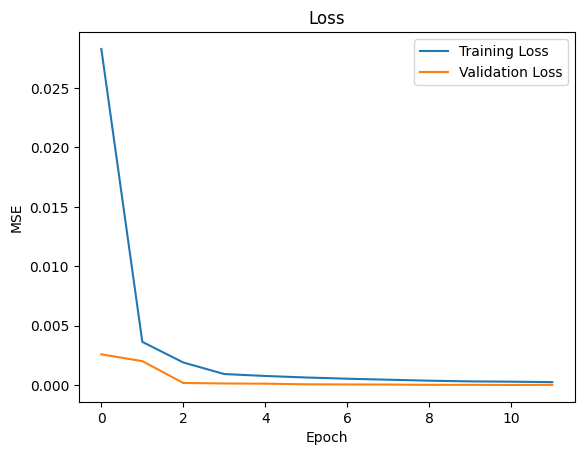

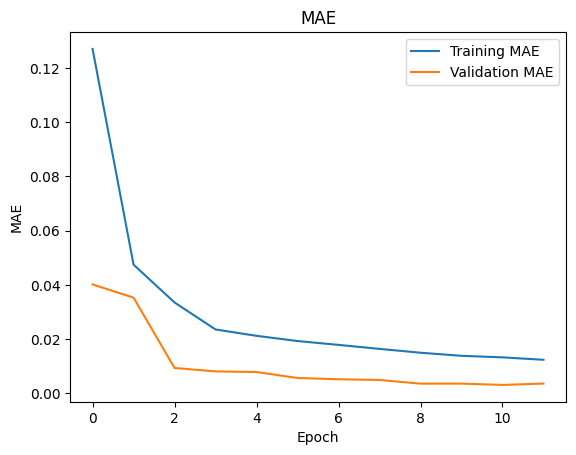

Test   MSE (scaled): 2.4584220227552578e-05   MAE (scaled): 0.0031507129315286875
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Test   MAE (DAC): 1.9439895416618185
Test   R²: 0.9901939432250255


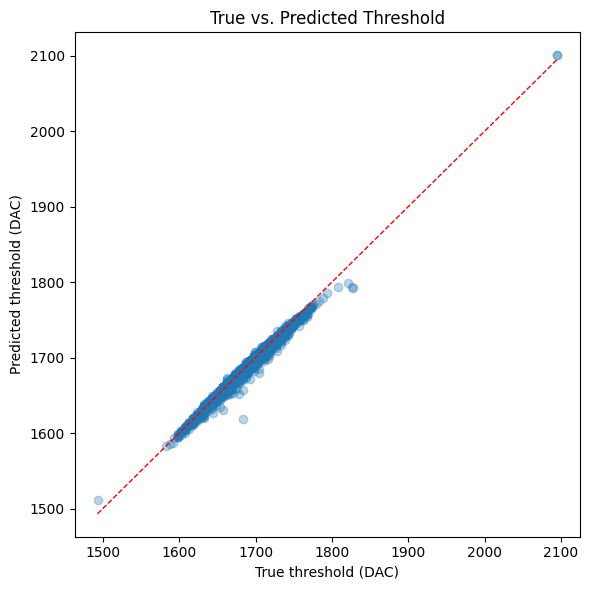

In [25]:
# --- 4) Evaluate & plot -----------------------------

# Loss / MAE curves
plt.figure()
plt.plot(history.history['loss'],    label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.legend(); plt.title('Loss')
plt.show()

plt.figure()
plt.plot(history.history['mae'],     label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch'); plt.ylabel('MAE'); plt.legend(); plt.title('MAE')
plt.show()

# Metrics on test set
test_mse, test_mae = model_trim15.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print("Test   MSE (scaled):", test_mse, "  MAE (scaled):", test_mae)

# Back-transform predictions to DAC units
y_pred_scaled = model_trim15.predict(X_test_scaled).flatten()
y_pred        = y_pred_scaled * (y_max - y_min) + y_min
y_true        = y_test_scaled * (y_max - y_min) + y_min

print("Test   MAE (DAC):", mean_absolute_error(y_true, y_pred))
print("Test   R²:",           r2_score(y_true, y_pred))

# Scatter plot True vs. Predicted
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.3)
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         'r--', linewidth=1)
plt.xlabel('True threshold (DAC)')
plt.ylabel('Predicted threshold (DAC)')
plt.title('True vs. Predicted Threshold')
plt.tight_layout()
plt.show()


## Test on other sensors for trim 15

In [24]:
gmax, gmin = compute_global_range_centered(
    sensor_min=1380,
    sensor_max=1820,
    total_steps=177,
    step_size=5
)
print(f"gmax: {gmax}, gmin: {gmin}")

gmax: 2040, gmin: 1155


In [27]:
# test on other sensors with trim 15

header = SimpleNamespace(
    min_thr    = 1155,
    max_thr    = 2040,
    step_size  =   5,
    vp         = 'VP1-1_trim15',
    trim       =    0,
    readable   = 'DAC threshold scan for VP1-1 trim15'  # will go in the CSV header
)
ana = Analyse()

d_mean_5_trim15, d_std_5_trim15, rate_5_trim15 = ana.threshold_scan(
    _trim_15_normalized_stack_5,
    header,
    save  = 1,
    slope = 'right',
    path  = out_folder
)

Processing a threshold scan...
...time for computing mean & std is  0.28705477714538574
...saving mean & std, time elapsed:  0.0950613021850586
...computing noise rate, time elapsed:  0.07550573348999023


Sensor 5 Trim15  MAE (DAC): 51.90
Sensor 5 Trim15  R²:          -1.591


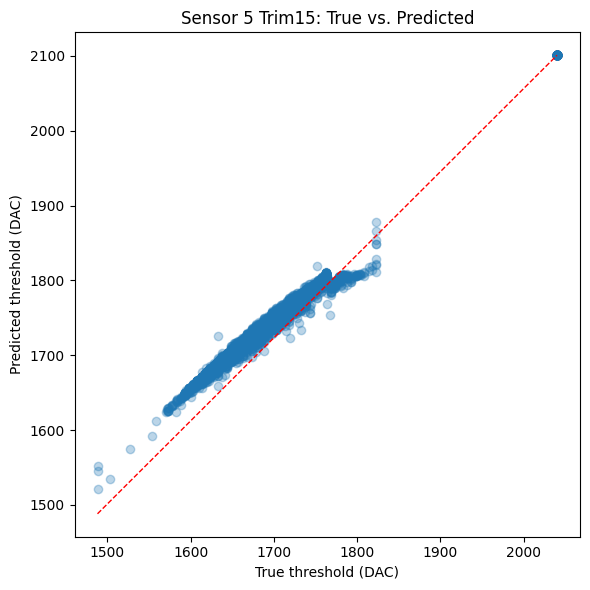

In [28]:
# --- Prep the inputs for sensor 5, trim15 -------------------

# 1) reshape into (177,256,256)
raw_counts_5_trim15 = _trim_15_normalized_stack_5.astype(np.uint32).reshape(177, 256, 256)

# 2) reorder to (256,256,177)
raw_counts_5_trim15 = raw_counts_5_trim15.transpose(1, 2, 0)

# 3) flatten to (256*256, 177) and add channel dim → (n_pixels, 177, 1)
X5_trim15 = raw_counts_5_trim15.reshape(-1, 177)[:, :, np.newaxis]

# 4) scale with the SAME scaler_X you used to train model_trim15
X5_trim15_flat   = X5_trim15.reshape(-1, 177)
X5_trim15_scaled = scaler_X.transform(X5_trim15_flat).reshape(-1, 177, 1)

# --- Prepare the true targets for sensor 5, trim15 ----------------------

y5_trim15         = rate_5_trim15.reshape(-1)
y5_trim15_scaled  = (y5_trim15 - y_min) / (y_max - y_min)

# --- Run inference & metrics with model_trim15 ----------------------

# 1) get scaled predictions
y5_pred_trim15_scaled = model_trim15.predict(X5_trim15_scaled, verbose=0).flatten()

# 2) back-transform to DAC units
y5_pred_trim15        = y5_pred_trim15_scaled * (y_max - y_min) + y_min

# 3) compute error metrics
from sklearn.metrics import mean_absolute_error, r2_score
mae5_trim15 = mean_absolute_error(y5_trim15, y5_pred_trim15)
r2_5_trim15 = r2_score(y5_trim15, y5_pred_trim15)

print(f"Sensor 5 Trim15  MAE (DAC): {mae5_trim15:.2f}")
print(f"Sensor 5 Trim15  R²:          {r2_5_trim15:.3f}")

# --- Optional: scatter plot ------------------------

import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y5_trim15, y5_pred_trim15, alpha=0.3)
plt.plot([y5_trim15.min(), y5_trim15.max()],
         [y5_trim15.min(), y5_pred_trim15.max()],
         'r--', linewidth=1)
plt.xlabel('True threshold (DAC)')
plt.ylabel('Predicted threshold (DAC)')
plt.title('Sensor 5 Trim15: True vs. Predicted')
plt.tight_layout()
plt.show()


# Old NN and Analyze class for trim computing

## Try with Neural Network (old)

In [ ]:
thr_range = np.arange(1845, 1395, -5)   # 1845, 1840, …, 1400 → length = (1845–1395)/5 = 90
n_thr = 90
X = data.reshape(n_thr, -1).T     # → (256*256, 90)  each row = one pixel’s 90-length profile
y = rate.ravel()                  # → (256*256,)    each entry = that pixel’s DAC threshold

In [ ]:
# number of scans (for now it's 1, but later the network might be trained on more data)
# M = 1
# X_all.shape == (M * 256*256, 90)
# y_all.shape == (M * 256*256,)

In [ ]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(90,)),     # fixed input length
    layers.Dense(128, activation='relu'),
    layers.Dense(64,  activation='relu'),
    layers.Dense(1),               # output = predicted DAC
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=1024
)


Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2045259.3750 - mae: 1394.4900 - val_loss: 107574.0312 - val_mae: 248.9545
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 90253.5469 - mae: 231.0621 - val_loss: 60280.7461 - val_mae: 201.0914
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 56991.5898 - mae: 195.0935 - val_loss: 49869.8086 - val_mae: 182.1061
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 45526.0898 - mae: 174.1459 - val_loss: 32879.8984 - val_mae: 147.9254
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 27441.4980 - mae: 135.4442 - val_loss: 15484.1650 - val_mae: 99.4284
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 11383.1709 - mae: 86.0060 - val_loss: 5553.1934 - val_mae: 51.7142
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3778.8145 - mae: 44.2397 - val_loss: 3091.5662 - val_mae: 31.0921
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1979.4182 - mae: 28.8057 - val_loss: 2517.2561

In [ ]:
# Predict data for new scans (more files would be helpful)
X_new   = data.reshape(90, -1).T    # (65536,90)
y_pred  = model.predict(X_new).reshape(256,256)

2048/2048 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [ ]:
# Count the global threshold
global_thr_nn = np.mean(y_pred[y_pred != 0])
print(f"Global threshold: {global_thr_nn}")

Global threshold: 1638.5208740234375


## Optimized neural network (old)

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# prepare data
n_thr = 90
X = data.reshape(n_thr, -1).T    # (65536,90)
y = rate.ravel()

# normalize per-pixel
Xn = X / np.maximum(X.max(axis=1, keepdims=True), 1e-6)

Xtr, Xvl, ytr, yvl = train_test_split(Xn, y, test_size=0.2, random_state=42)

# build model
model = tf.keras.Sequential([
  tf.keras.layers.Reshape((90,1), input_shape=(90,)),
  tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same'),
  tf.keras.layers.Conv1D(16, 3, activation='relu', padding='same'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu',
      kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
  tf.keras.layers.Dense(1),
])
model.compile(
  optimizer=tf.keras.optimizers.Adam(1e-3),
  loss=tf.keras.losses.Huber(1.0),
  metrics=['mae']
)

# train with callbacks
es  = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
rlr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)

history = model.fit(
  Xtr, ytr,
  validation_data=(Xvl, yvl),
  epochs=50,
  batch_size=1024,
  callbacks=[es, rlr]
)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - loss: 1622.9600 - mae: 1623.4486 - val_loss: 1357.3718 - val_mae: 1357.8517 - learning_rate: 0.0010
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - loss: 896.6472 - mae: 897.1168 - val_loss: 82.5543 - val_mae: 83.0071 - learning_rate: 0.0010
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 82.2699 - mae: 82.7225 - val_loss: 69.2418 - val_mae: 69.6945 - learning_rate: 0.0010
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - loss: 66.5771 - mae: 67.0291 - val_loss: 58.2462 - val_mae: 58.6968 - learning_rate: 0.0010
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - loss: 55.1268 - mae: 55.5772 - val_loss: 46.6783 - val_mae: 47.1275 - learning_rate: 0.0010
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - loss: 43.6831 - mae: 44.1316 - val_loss: 35.1657 - val_mae: 35.6120 - learning_rate: 0.0010
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - loss: 31.9690 - mae: 32.4154 - val_loss: 24.2139 - val_mae: 24.6590 - learn

In [ ]:
import numpy as np

# Flatten and normalize test data (per-pixel max scaling)
n_thr = 90
X_test = data.reshape(n_thr, -1).T            # (256*256, 90)
X_max  = np.maximum(X_test.max(axis=1, keepdims=True), 1e-6)
X_test_norm = X_test / X_max

# Predict per-pixel thresholds
y_pred = model.predict(X_test_norm, batch_size=1024)  # shape (65536,1)

# Reshape to 256×256 map
rate_pred = y_pred.reshape(256, 256)

# Compute the global threshold (mean of non-zero predictions)
global_thr_pred = np.mean(rate_pred[rate_pred != 0])

print("Per-pixel prediction map shape:", rate_pred.shape)
print("Global predicted threshold:", global_thr_pred)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step
Per-pixel prediction map shape: (256, 256)
Global predicted threshold: 1638.9089


## Analyze code with all methods (including compute_trim)

### Headers for low and high trim values

In [ ]:
from types import SimpleNamespace

header_0 = SimpleNamespace(
    min_thr    = 1395,
    max_thr    = 1845,
    step_size  =   5,
    vp         = 'VP0-0',
    trim       =    0,                         # or whatever initial trim
    readable   = 'DAC threshold scan for VP0-0'  # will go in the CSV header
)

header_15 = SimpleNamespace(
    min_thr    = 1395,
    max_thr    = 1845,
    step_size  =   5,
    vp         = 'VP0-0',
    trim       =    15,                         # or whatever initial trim
    readable   = 'DAC threshold scan for VP0-0'  # will go in the CSV header
)


### Analyze class

In [ ]:
import time
import numpy as np
import glob as glob
import matplotlib.pyplot as plt


class Analyse():
    def __init__(
        self
    ):
        """
        """

    def threshold_scan(self, data, header, save = 1, slope = 'right', path = ''):
        print("Processing a threshold scan...")

        start = time.time()
        thr_range = np.arange(header.max_thr , header.min_thr , -header.step_size)
        data = data.astype(dtype = np.uint32).reshape((-1,256,256))
        d_mean, d_std = self.threshold_mean_std(data, thr_range)

        end = time.time()
        print("...time for computing mean & std is ", end - start)

        if save == 1:
            start = time.time()
            np.savetxt(path + header.vp + '_scan' + str(header.trim) + '_mean.csv', d_mean, delimiter = ',',
                    header = header.readable, fmt = '%.2f')
            np.savetxt(path + header.vp + '_scan' + str(header.trim) + '_std.csv', d_std, delimiter = ',',
                    header = header.readable, fmt = '%.2f')
            end = time.time()
            print("...saving mean & std, time elapsed: ", end - start)

        #start = time.time()
        rate = self.threshold_rate(data, header.min_thr, header.max_thr, header.step_size, slope = slope)

        if save == 1:
            np.savetxt(path + header.vp + '_scan' + str(header.trim) + '_rate.csv', rate, delimiter = ',',
                    header = header.readable, fmt = '%.u')
        #end = time.time()
        #print("...computing noise rate, time elapsed: ", end - start)
        return d_mean, d_std, rate

    def generate_mask_recipe(self, dmean, drate, header, cond, path = ''):
        print(f"Generating mask for {cond} DAC threshold ...")
        maskmap = np.zeros([256,256])
        mdmean = np.mean(dmean, where = dmean != 0)
        maskmap[(mdmean + cond - drate) <= 0] = 1
        print(f'... masked {np.sum(maskmap)} pixels')
        np.savetxt(path + header.vp + '_mask_recipe.csv', maskmap, delimiter = ',', fmt = '%.u')
        return maskmap

    def generate_thr_recipe(self, dmean, header, cond, path = '') -> int:
        print(f"Generating threshold for {cond} DAC threshold ...")
        mdmean = np.mean(dmean, where = dmean != 0)
        thr = np.array([mdmean + cond])
        print(f'... computed threshold at {thr} DAC')
        np.savetxt(path + header.vp + '_threshold_recipe.csv', thr, fmt = '%.u')
        return thr

    def build_mask_pattern(self, ravel = False, build4 = False) -> np.ndarray:
        mask = np.ones([256,256])
        mask[:,::2] = 2
        mask[15::16, 1::2] = 3
        if build4 == True:
            mask[15::16, ::2] = 4
        if ravel == True:
            return mask.ravel()
        else:
            return mask

    def zeros(self, a, b):
        return np.zeros([a, b])

    def compute_trim_old(self, vp, rate_0, rate_F, save = 1):
        print("\nEqualising...")
        mean_0, mean_F = np.mean(rate_0), np.mean(rate_F)

        target = 1/2 * (mean_0 + mean_F)
        #max_trim = 15

        trim = np.zeros([256, 256])
        print("Zero elements: ", np.count_nonzero(mean_0 == 0), np.count_nonzero(mean_F == 0))
        #counters = 0
        trim_scale = 1.*(rate_F - rate_0) / 15
        #print("Trim scale lower than 0: ", np.count_nonzero(trim_scale <= 0))
        #print(trim, trim_scale, target_even, target_odd, target_16th)
        if trim_scale is not None:
            trim = np.round(np.divide((target - rate_0),
                trim_scale, where = trim_scale != 0))
            trim[trim > 15] = 15
            trim[trim < 0 ] = 0

        if save == 1:
            start = time.time()
            np.savetxt(path + vp + '_trim_recipe.csv', trim, delimiter = ',', fmt = '%.u')
            #np.savetxt(path + vp + '_mask_recipe.csv', np.zeros([256,256]), delimiter = ',', fmt = '%.u')
            end = time.time()
            print("...saving recipe, time elapsed: ", end - start)

    def compute_trim(self, vp, rate_0, rate_F, save = 1, path = ''):
        print("\nEqualising...")
        #mean_0, mean_F = np.mean(rate_0), np.mean(rate_F)

        mask = self.build_mask_pattern()

        target_even = 1/2 * (np.mean(rate_0[mask == 2]) + np.mean(rate_F[mask == 2]))
        target_odd = 1/2 * (np.mean(rate_0[mask == 1]) + np.mean(rate_F[mask == 1]))
        target_16th = 1/2 * (np.mean(rate_0[mask == 3]) + np.mean(rate_F[mask == 3]))
        target_16th = target_odd - 5
        #target = 1/2 * (mean_0 + mean_F)
        #max_trim = 15

        trim = np.zeros([256, 256])

        #print("Zero elements: ", np.count_nonzero(mean_0 == 0), np.count_nonzero(mean_F == 0))
        #counters = 0
        trim_scale = 1.*(rate_F - rate_0) / 15
        #print("Trim scale lower than 0: ", np.count_nonzero(trim_scale <= 0))
        if trim_scale is not None:
            trim[mask == 2] = np.round(np.divide((target_even - rate_0[mask == 2]),
                trim_scale[mask == 2], where = trim_scale[mask == 2] != 0))
            trim[mask == 1] = np.round(np.divide((target_odd - rate_0[mask == 1]),
                trim_scale[mask == 1], where = trim_scale[mask == 1] != 0))
            trim[mask == 3] = np.round(np.divide((target_16th - rate_0[mask == 3]),
                trim_scale[mask == 3], where = trim_scale[mask == 3] != 0))
            trim[trim > 15] = 15
            trim[trim < 0 ] = 0

        if save == 1:
            start = time.time()
            np.savetxt(path + vp + '_trim_recipe.csv', trim, delimiter = ',', fmt = '%.u')
            #np.savetxt(path + vp + '_mask_recipe.csv', np.zeros([256,256]), delimiter = ',', fmt = '%.u')
            end = time.time()
            print("...saving recipe, time elapsed: ", end - start)

    def threshold_rate(self, data, min_thr, max_thr, step_size, slope = 'right'):
        if slope == 'left':
            data = np.flip(data, axis = 0)
        satmax = np.argmax(data > 31.5, axis = 0)
        #satmax[satmax == 0] = np.nan
        slopemax_l = np.float32(data[satmax, np.arange(256)[:, np.newaxis], np.arange(256)])
        slopemax_h = np.float32(data[satmax - 1, np.arange(256)[:, np.newaxis], np.arange(256)])
        grad = (slopemax_h - slopemax_l)/(step_size)
        if slope == 'right':
            dacmax = (max_thr - satmax * step_size)
        elif slope == 'left':
            dacmax = (min_thr + satmax * step_size)
        #satmax_dac[satmax_dac == 1950] = 0
        grad[grad == 0.0] = float('inf')
        slopemid = np.round(dacmax - (slopemax_l - 31.5)/grad)
        return slopemid

    def threshold_mean_std(self, data, thr_range):
        if data.dtype != np.uint32:
            data = data.astype(dtype = np.uint32)

        d_total = np.sum(data, axis = 0, dtype = np.float32)
        d_total[d_total == 0] = np.nan
        d_times_thr = data * thr_range[:, np.newaxis, np.newaxis]
        d_integral = np.sum(d_times_thr, axis = 0)
        d_mean = np.divide(d_integral, d_total)#, where = (d_total != 0))

        m_squared = np.array([np.full((256,256), thr) - d_mean for thr in thr_range]) ** 2
        d_times_squared = data * m_squared
        d_integral = np.sum(d_times_squared, axis = 0)
        d_sigma = np.sqrt(d_integral/d_total)

        d_mean = np.nan_to_num(d_mean, nan = 0)#.astype(np.uint32)
        d_sigma = np.nan_to_num(d_sigma, nan = 0)

        return d_mean, d_sigma


    def threshold_std(self, data, thr_range):
        if data.dtype != np.uint32:
            data = data.astype(dtype = np.uint32)
        m_squared = np.array([np.full((256,256), thr) - d_mean for thr in thr_range]) ** 2
        d_times_squared = data * m_squared
        d_integral = np.sum(d_times_squared, axis = 0)
        d_sigma = np.sqrt(d_integral / d_total)

    def compute_boundary(self, dist, cond, bin):
        N, bins = np.histogram(dist, bins = bin)
        min_u, max_u = None, None
        for it in range(len(N)-1):
            if N[it] > cond:
                max_u = bins[it]
            if N[-1-it] > cond:
                min_u = bins[-1-it]
        if min_u is not None and max_u is not None:
            return min_u, max_u
        else:
            return np.nan, np.nan

    def mean_std(self, scan, precision = 2, skip_zeros = False):
        try:
            if skip_zeros == False:
                scan_mean = round(np.nanmean(scan), precision)
                scan_std = round(np.nanstd(scan), precision)
            else:
                scan_mean = round(np.nanmean(scan[scan!=0]), precision)
                scan_std = round(np.nanstd(scan[scan!=0]), precision)
        except:
            scan_mean, scan_std = np.nan, np.nan
        return scan_mean, scan_std

    def find_pixel(self, key, vp, cond):
        total = 0
        # TODO: redefine accessing file from google colab
        # try:
        #     data = self.open_csv(vp, nt.name[key], skiprows = 0)
        # except:
        #     data = self.open_csv(vp, nt.name[key], skiprows = 1)
        for i in range(256):
            for j in range(256):
                if cond(data[i,j]):
                    print('X: ', i, ' Y: ', j )
                    total += 1
        print("Found " + str(total) + ' pixels meeting criteria')

    def analyse_distance(self, mfile, vp, date, opt):
        if vp == 'VP0-0':
            mfile.write('VP,mean,std,min,max,min0,max0,minF,maxF,mask\n')

        # TODO: define separate paths to these files
        # mask = self.open_csv(vp, nt.name[opt[0]], date, skiprows = 0)
        # scan_0 = self.open_csv(vp, nt.name[opt[1]], date, skiprows = 1)
        # scan_F = self.open_csv(vp, nt.name[opt[2]], date, skiprows = 1)

        if (scan_0 is None) or (scan_F is None):
            return None

        dist = abs((scan_F - scan_0).ravel())

        if (mask is not None):
            masked = np.sum(mask)
            for pix in range(256* 256):
                if mask[pix] == 1:
                    dist[pix] = np.nan

        bin_array = np.linspace(0,500,251)

        N, bins = np.histogram(dist, bins = bin_array)

        mean = round(np.nanmean(dist), 2)
        std = round(np.nanstd(dist), 2)
        mind, maxd = self.compute_boundary(dist, cond = 10, bin = bin_array)
        bin_array = np.linspace(1000,2000,201)
        min0, max0 = self.compute_boundary(scan_0, cond = 5, bin = bin_array)
        minF, maxF = self.compute_boundary(scan_F, cond = 5, bin = bin_array)

        mfile.write(vp)
        mfile.write(',' + str(mean) + ',' + str(std) + ',' + str(mind) +
                    ',' + str(maxd) + ',' + str(min0) + ',' + str(max0) + ','
                    + str(minF) + ',' + str(maxF) + ',' + str(masked) + '\n')

    def find_ipixeldac(self, rate_0, rate_F, fn):
        dist = abs((rate_F - rate_0))
        dist_mean = np.mean(dist, where = dist > 0)
        aim_interval = 185
        ipixeldac_default = 90
        tr_factor = 2.49
        dac_to_add = ((aim_interval - dist_mean)/tr_factor)

        ipixeldac = int(ipixeldac_default + dac_to_add)
        with open(fn, "a") as file:
            file.write(f"{ipixeldac}")
        print("Compute ipixeldac to ", ipixeldac)
        return ipixeldac

    def find_range(self, mean, trim, fn, ipixeldac = None):
        if not mean.any():
            return None

        low_thr = np.mean(mean, where = mean != 0) - 7.5*np.std(mean, where = mean != 0)
        high_thr = np.mean(mean, where = mean != 0) + 7.5*np.std(mean, where = mean != 0)
        if trim == 0x0:
            low_thr -= (ipixeldac-90)*2
            high_thr -= (ipixeldac-90)
        elif trim == 0xF:
            low_thr += (ipixeldac-90)
            high_thr += (ipixeldac-90)*2
        if high_thr > 1980: high_thr = 1980

        low_thr = int(np.round(low_thr/5)*5)
        high_thr = int(np.round(high_thr/5)*5)

        with open(fn, "a") as file:
            file.write(f"trim{trim}low_{low_thr}\n")
            file.write(f"trim{trim}hgh_{high_thr}\n")

        print("Compute range ", low_thr, high_thr)

    def find_range_control(self, rate_0, rate_F, fn):
        if not rate_0.any():
            return None

        #2.5 is a conversion between width and sigma when computed on width of 2 step sizes, 35 is ~max. noise expected
        low_thr = int(np.mean(rate_F, where = rate_F != 0) - 4.5*np.std(rate_F, where = rate_F != 0) - 2.5 * 35)
        high_thr = int(np.mean(rate_0, where = rate_0 != 0) + 6*np.std(rate_0, where = rate_0 != 0))

        with open(fn, "a") as file:
            file.write(f"low_{low_thr}\n")
            file.write(f"high_{high_thr}")
        print("Compute range ", low_thr, high_thr)



### Generate output files

In [ ]:
ana = Analyse()

# define an output folder in Drive
out_folder = '/content/drive/MyDrive/magisterka/results/'
import os
os.makedirs(out_folder, exist_ok=True)

# reshape & compute mean/std/rate, and save CSVs into your results folder
d_mean_0, d_std_0, rate_0 = ana.threshold_scan(
    data,
    header_0,
    save  = 1,
    slope = 'right',
    path  = out_folder
)

d_mean_15, d_std_15, rate_15 = ana.threshold_scan(
    data,
    header_15,
    save  = 1,
    slope = 'right',
    path  = out_folder
)


Processing a threshold scan...
...time for computing mean & std is  0.13392949104309082
...saving mean & std, time elapsed:  0.07100725173950195
Processing a threshold scan...
...time for computing mean & std is  0.11118745803833008
...saving mean & std, time elapsed:  0.09377932548522949


In [ ]:
# For trim 0
# mask pixels where rate is too high compared to mean + cond
# -> saved to file: VP0-0_mask_recipe.csv
mask_0 = ana.generate_mask_recipe(d_mean_0, rate_0, header_0, cond=10, path=out_folder)

# a single‐value threshold recipe (global DAC threshold)
thr_0 = ana.generate_thr_recipe(d_mean_0, header_0, cond=20, path=out_folder)

# For trim 15
mask_15 = ana.generate_mask_recipe(d_mean_15, rate_15, header_15, cond=10, path=out_folder)
thr_15 = ana.generate_thr_recipe(d_mean_15, header_15, cond=20, path=out_folder)


Generating mask for 10 DAC threshold ...
... masked 51021.0 pixels
Generating threshold for 20 DAC threshold ...
... computed threshold at [1620.99447497] DAC
Generating mask for 10 DAC threshold ...
... masked 51021.0 pixels
Generating threshold for 20 DAC threshold ...
... computed threshold at [1620.99447497] DAC


In [ ]:
# prompt: Print d_mean, d_std, rate, mask and thr (both in version _0 and _15)

print(f"d_mean_0:\n{d_mean_0}")
print(f"d_std_0:\n{d_std_0}")
print(f"rate_0:\n{rate_0}")
print(f"mask_0:\n{mask_0}")
print(f"thr_0:\n{thr_0}")

print(f"d_mean_15:\n{d_mean_15}")
print(f"d_std_15:\n{d_std_15}")
print(f"rate_15:\n{rate_15}")
print(f"mask_15:\n{mask_15}")
print(f"thr_15:\n{thr_15}")


In [ ]:
ana.compute_trim(
    vp     = header.vp,
    rate_0 = rate_0,
    rate_F = rate_15,
    save   = 1,
    path   = out_folder
)



Equalising...
...saving recipe, time elapsed:  0.03696298599243164
